<a href="https://colab.research.google.com/github/david-meltzer/quadratic_model/blob/main/catapult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook can be used to reproduce the numerical results of the paper as well as new experiments. The notebook was written to be used on Google colab, but can easily be modified to run on a local machine.

# Definitions

If save_files=True then the ntebook will mount google drive, import the required modules, cd to the folder containing the file, and create the "results" and "data" directory.

In [5]:
save_files=True


if save_files:
    # Mount google drive
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    #foldername should be changed to the name of the directory containing the file.
    foldername = '/quadratic_catapult/'
    %cd /content/drive/My\ Drive/$foldername

    import sys
    import os

    sys.path.append('/content/drive/My Drive/{}'.format(foldername))    
    
    #creates the 'results' and 'data' directories, if they don't exist.
    if not os.path.exists('results'):
        os.makedirs('results')

    if not os.path.exists('data'):
        os.makedirs('data')

Mounted at /content/drive
/content/drive/My Drive/quadratic_catapult


In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda

!pip install num2words
!pip install functorch

#sets device to cuda if available.
device = "cuda" if torch.cuda.is_available() else "cpu"

%matplotlib inline

# Automatically reloads imported files.
%load_ext autoreload
%autoreload 2

!git clone https://github.com/david-meltzer/quadratic_model.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
fatal: destination path 'quadratic_model' already exists and is not an empty directory.


In [7]:
%cd quadratic_model
from models import MLPGeneral, Quadratic, quadratic_with_bias
from misc import CustomDataset
from training import full_training_loop
from plots import produce_plots
%cd ..

/content/drive/My Drive/quadratic_catapult/quadratic_model
/content/drive/My Drive/quadratic_catapult


# Two-Class Datasets

Here we download MNIST, FMNIST, and CIFAR-10. We then construct two-class versions of all the datasets.

These datasets do not need to be downloaded to study the quadratic model.

In [ ]:
#Dictionary used to contain the datasets.
data={}

## MNIST

In this section we create a two-class version of MNIST, called MNIST01. It only contains images of '0' and '1'. Images of '0' have target -1 and images of '1' have target 1. 

From MNIST01 we create MNIST01_small, which only contains 128 images in its training set, but the same test set has MNIST01.

In [ ]:
data['MNIST','train'] = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

data['MNIST','test'] = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

#The code below is used to construct a two-class version of MNIST.
#Images with original target 0 are reassigned to have target -1
data['MNIST','train'].targets[data['MNIST','train'].targets==0]=-1
data['MNIST','test'].targets[data['MNIST','test'].targets==0]=-1

#Isolate images in training set with target -1 or +1.
idx_MNIST_0 = (data['MNIST','train'].targets==-1)
idx_MNIST_1 = (data['MNIST','train'].targets==1)

idx_MNIST_01 = idx_MNIST_0+idx_MNIST_1
idx_MNIST_01 = idx_MNIST_01.nonzero(as_tuple=True)[0]

#New dataset which just has targets -1 or +1.
data['MNIST01','train'] = Subset(data['MNIST','train'],idx_MNIST_01)

#Same as above for test set.
idx_MNIST_test_01 = (data['MNIST','test'].targets==-1)+(data['MNIST','test'].targets==1)
idx_MNIST_test_01 = idx_MNIST_test_01.nonzero(as_tuple=True)[0]

data['MNIST01','test'] = Subset(data['MNIST','test'],idx_MNIST_test_01)

#Define small, two-class training dataset to only contain 128 images.
#Test set contains all original images with targets -1 and +1.
data['MNIST01_small','train'] = Subset(data['MNIST','train'],idx_MNIST_01[:128])
data['MNIST01_small','test'] = data['MNIST01','test']

## FMNIST

Below we create the two class version of FMNIST, which we call FMNIST01. It consists of images in FMNIST with target 0 or target 1. Images with target 0 are reassigned to have target -1.

From FMNIST01 we construct FMNIST01_small, which only has 128 images in its training set. Its test set is the same as the test set of FMNIST01.

In [ ]:
data['FMNIST','train'] = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

data['FMNIST','test'] = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


data['FMNIST','train'].targets[data['FMNIST','train'].targets==0]=-1
data['FMNIST','test'].targets[data['FMNIST','test'].targets==0]=-1

idx_FMNIST_0 = (data['FMNIST','train'].targets==-1)
idx_FMNIST_1 = (data['FMNIST','train'].targets==1)

idx_FMNIST_01 = idx_FMNIST_0+idx_FMNIST_1
idx_FMNIST_01 = idx_FMNIST_01.nonzero(as_tuple=True)[0]

data['FMNIST01','train']  = Subset(data['FMNIST','train'],idx_FMNIST_01)

idx_FMNIST_test_01 = (data['FMNIST','test'].targets==-1)+(data['FMNIST','test'].targets==1)
idx_FMNIST_test_01 = idx_FMNIST_test_01.nonzero(as_tuple=True)[0]

data['FMNIST01','test']  = Subset(data['FMNIST','test'],idx_FMNIST_test_01)

data['FMNIST01_small','train']  = Subset(data['FMNIST','train'],idx_FMNIST_01[:128])
data['FMNIST01_small','test']  = data['FMNIST','test']

## CIFAR-10

Below we create the two class version of CIFAR-10, which we call CIFAR10_01. It consists of images in CIFAR-10 with target 0 or target 1. Images with target 0 are reassigned to have target -1.

From CIFAR10_01 we construct CIFAR10_01_small, which only has 128 images in its training set. Its test set is the same as the test set of CIFAR10_01.

In [ ]:
data['CIFAR10','train']  = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

data['CIFAR10','test'] = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

for i,x in enumerate(data['CIFAR10','train'].targets):
    if x==0:
        data['CIFAR10','train'].targets[i]=-1

for i,x in enumerate(data['CIFAR10','test'].targets):
    if x==0:
        data['CIFAR10','test'].targets[i]=-1

idx_CIFAR10_0 = (torch.tensor(data['CIFAR10','train'].targets)==-1)
idx_CIFAR10_1 = (torch.tensor(data['CIFAR10','train'].targets)==1)

idx_CIFAR10_01 = idx_CIFAR10_0+idx_CIFAR10_1
idx_CIFAR10_01 = idx_CIFAR10_01.nonzero(as_tuple=True)[0]

data['CIFAR10_01','train'] = Subset(data['CIFAR10','train'],idx_CIFAR10_01)

idx_CIFAR10_test_0 = (torch.tensor(data['CIFAR10','test'].targets)==-1)
idx_CIFAR10_test_1 = (torch.tensor(data['CIFAR10','test'].targets)==1)

idx_CIFAR10_test_01 = idx_CIFAR10_test_0+idx_CIFAR10_test_1
idx_CIFAR10_test_01 = idx_CIFAR10_test_01.nonzero(as_tuple=True)[0]

data['CIFAR10_01','test'] = Subset(data['CIFAR10','test'],idx_CIFAR10_test_01)

data['CIFAR10_01_small','train']  = Subset(data['CIFAR10_01','train'],idx_CIFAR10_01[:128])
data['CIFAR10_01_small','test']  = data['CIFAR10_01','test']

# Figures

Below we present the code used to construct the figures presented in the paper. With the exception of the experiments run on MNIST, FMNIST, and CIFAR-10, the code can be run on a cpu. The other experiments should be run using a gpu so they can be done in a reasonable time.

For all experiments, we train the model until the model converges. For experiments run on MNIST, FMNIST, and CIFAR-10 our criteria for convergence was that the change in the training set loss was less than $10^{-8}$. However, reasonable results can be obtained by making the stop criteria weaker.

Disclaimer: some figures may differ slightly from results presented in the paper due to different seeds, but all results are qualitatively the same.

## Figure 1: Pure Quadratic, Toy dataset

computing averaged top eigenvalues and eigenvectors
eigenvalues already computed

Training at lr_ratio: 0.1
training already done
Computing final values of train and/or test loss.

Training at lr_ratio: 0.2
training already done
Computing final values of train and/or test loss.

Training at lr_ratio: 0.3
training already done
Computing final values of train and/or test loss.

Training at lr_ratio: 0.4
training already done
Computing final values of train and/or test loss.

Training at lr_ratio: 0.5
training already done
Computing final values of train and/or test loss.

Training at lr_ratio: 0.6
training already done
Computing final values of train and/or test loss.

Training at lr_ratio: 0.7
training already done
Computing final values of train and/or test loss.

Training at lr_ratio: 0.8
training already done
Computing final values of train and/or test loss.

Training at lr_ratio: 0.9
training already done
Computing final values of train and/or test loss.

Training at lr_ratio: 1.0
t

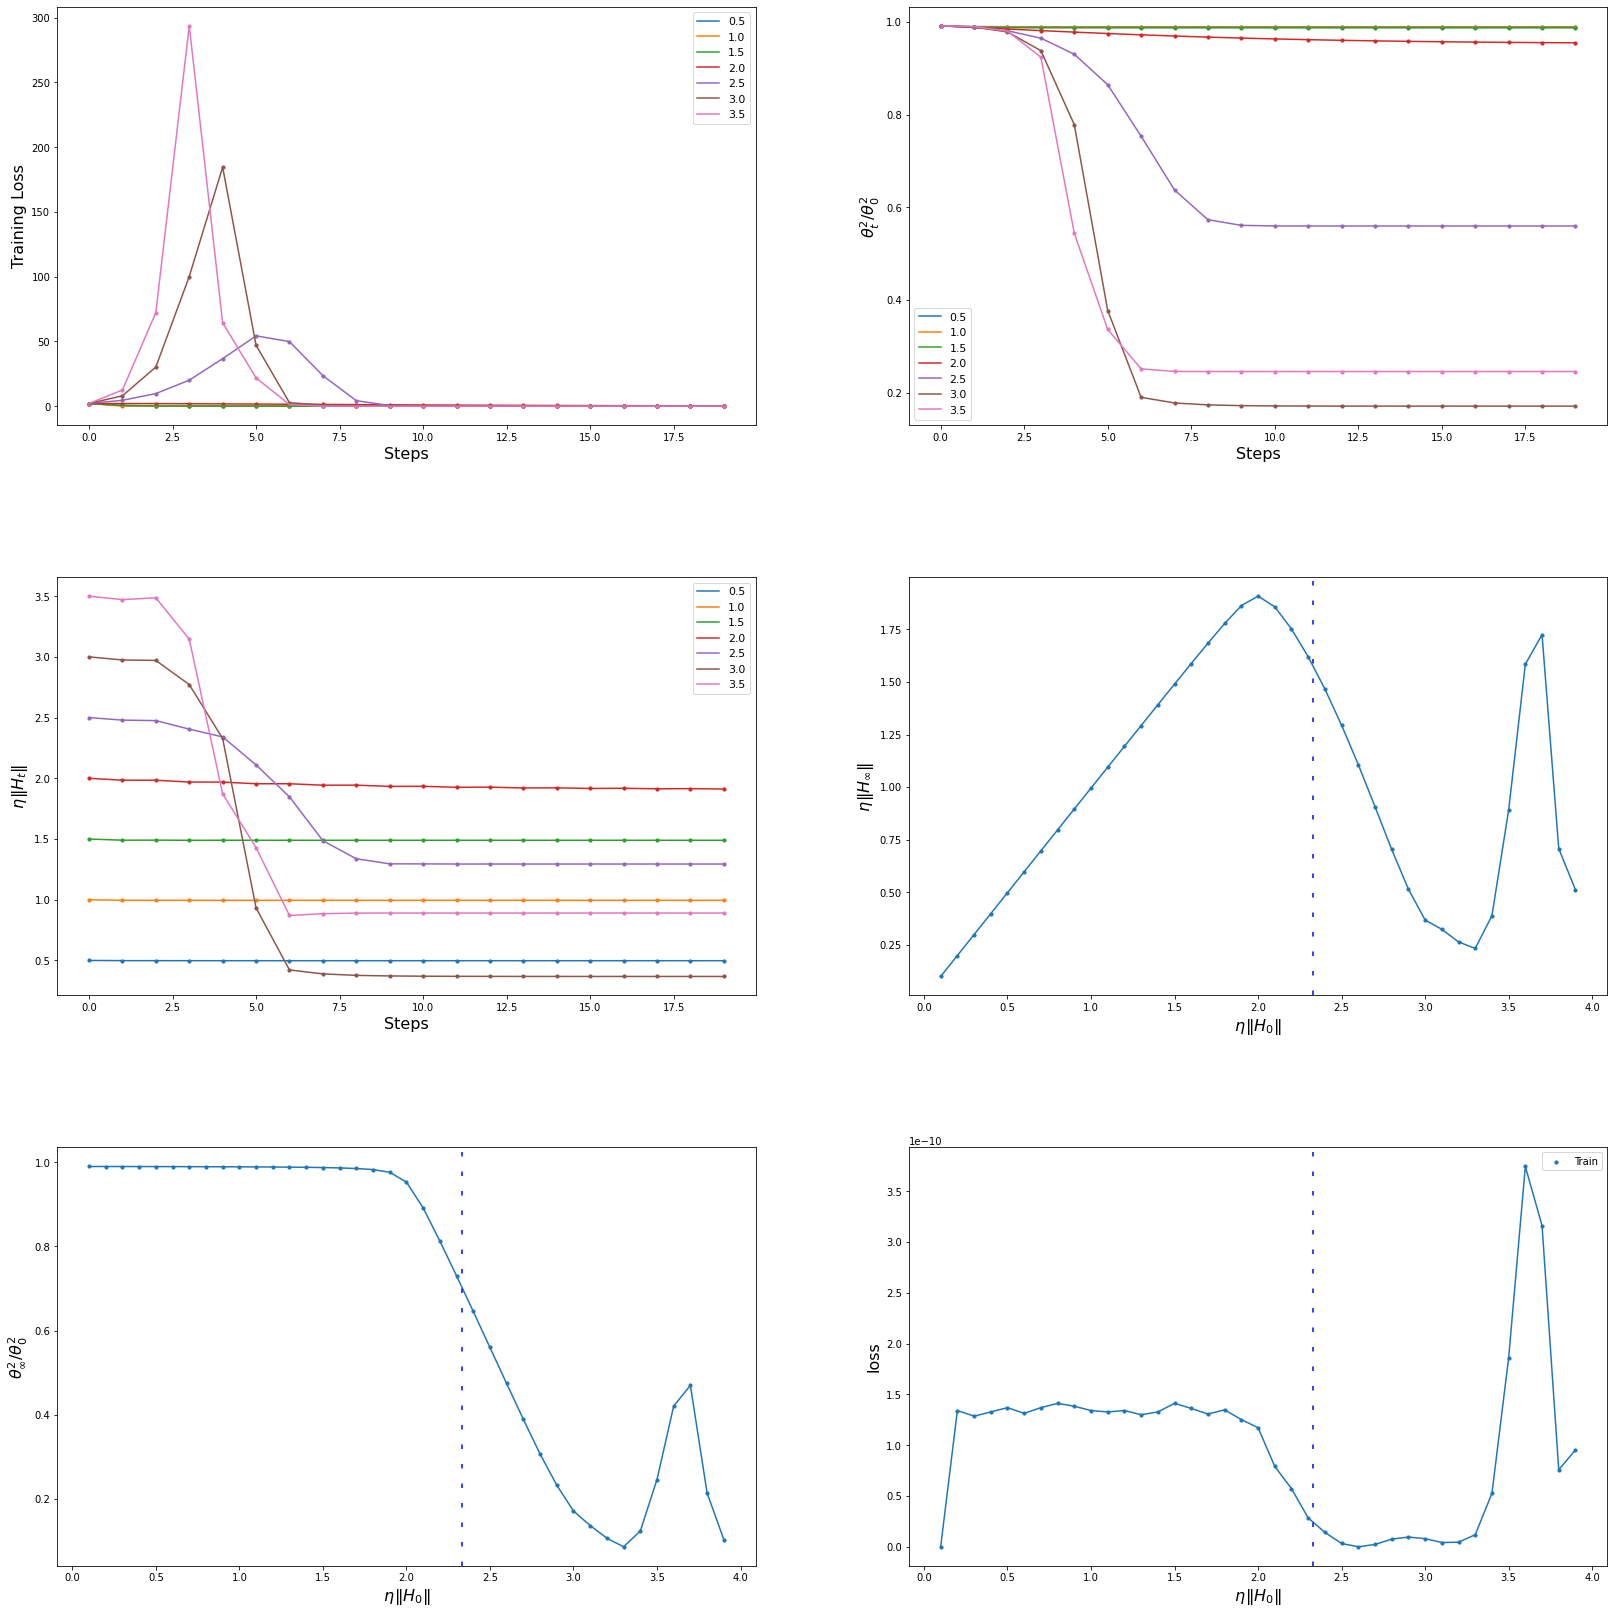

In [8]:
model_dict={}

# Dimensionality of the input data.
model_dict['input_dim']=1
# Rank of the meta-feature function.
model_dict['hidden_dim']=1000
# Device the experiment is performed on.
model_dict['device']=device
#Training batch size.
train_batch_size=1

#eval_dist defines the distribution the eigenvalues lambda^i_sigma are drawn from.
#See eqn 186.
eval_dist={}
# Draw the eigenvalues from a uniform distribution.
eval_dist['dist']='uniform'
# Distribution is uniform over [1,2].
eval_dist['params']=(1,2)
# Store eval_dist in the dictionary model_dict.
model_dict['eval_dist']=eval_dist

#matrix_dist defines the distribution used to construct the matrix W.
#Specifically, the independent elements of B (see equation 187) are drawn from this distribtion.
#The matrix q is obtained from exponentiating B and the matrix W is constructed
#from the eignvalues and the matrix q (see equation 186)
matrix_dist={}
#Draw from the normal distribution
matrix_dist['dist']='normal'
#Mean is 0 and variance is 1.
matrix_dist['params']=(0,1)
#Store matrix_dist in the dictionary model_dict.
model_dict['matrix_dist']=matrix_dist

dataset={}
#Name of dataset being studied. Used in filename when saving results.
dataset['name']='toy_example'
#Definition of training set. No test set in this example.
dataset['train']=CustomDataset(list(zip(torch.tensor([[1.0]]),torch.tensor([[0.0]]))))

#list of normalized learning rates to study.
lr_ratios=list(map(lambda x:round(x,2),np.arange(.1,4+.1,.1)))
#max_epochs=maximum number of epochs to train for.
max_epochs=1000
# Stop training when change in loss is less than stop_critersion.
stop_criterion=0
# Seed used to construct random number of generator.
seed=13

#Use the pure quadratic model.
arch=Quadratic

#Run the training and store results in dictionary 'result'.
result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None, #If not None, used to load existing results.
                    device=device,
                    seed=seed,
                    printevery=250,
                    verbose=True, #If true, progress of training is printed.
                    write_file=save_files,#If true, the model and results are saved.
                    overwrite=False,#If true, existing results are overwritten.
                    data_eigen=False)#If true, the top eigenvalue of covariance matrix is computed.

#Produce plots used in paper.
produce_plots(result,
              xmin=0, #Lower range for x-axis when plotting results vs steps.
              xmax=20,# Upper range for x-axis when plotting results vs steps.
              include_predictions=True, #If true, include theoretical predictions.
              mult_data=False, #Set to true if training set contains >1 datapoint.
              s=10, 
              size=(25,25),
              offset=4,
              skip=5)

## Figure 2: Scale-Invariant (slope 1/2), Two-Layer, Toy dataset

computing averaged top eigenvalues and eigenvectors
eigenvalues already computed

Training at lr_ratio: 0.1
training already done

Training at lr_ratio: 0.2
training already done

Training at lr_ratio: 0.3
training already done

Training at lr_ratio: 0.4
training already done

Training at lr_ratio: 0.5
training already done

Training at lr_ratio: 0.6
training already done

Training at lr_ratio: 0.7
training already done

Training at lr_ratio: 0.8
training already done

Training at lr_ratio: 0.9
training already done

Training at lr_ratio: 1.0
training already done

Training at lr_ratio: 1.1
training already done

Training at lr_ratio: 1.2
training already done

Training at lr_ratio: 1.3
training already done

Training at lr_ratio: 1.4
training already done

Training at lr_ratio: 1.5
training already done

Training at lr_ratio: 1.6
training already done

Training at lr_ratio: 1.7
training already done

Training at lr_ratio: 1.8
training already done

Training at lr_ratio: 1.9
training a

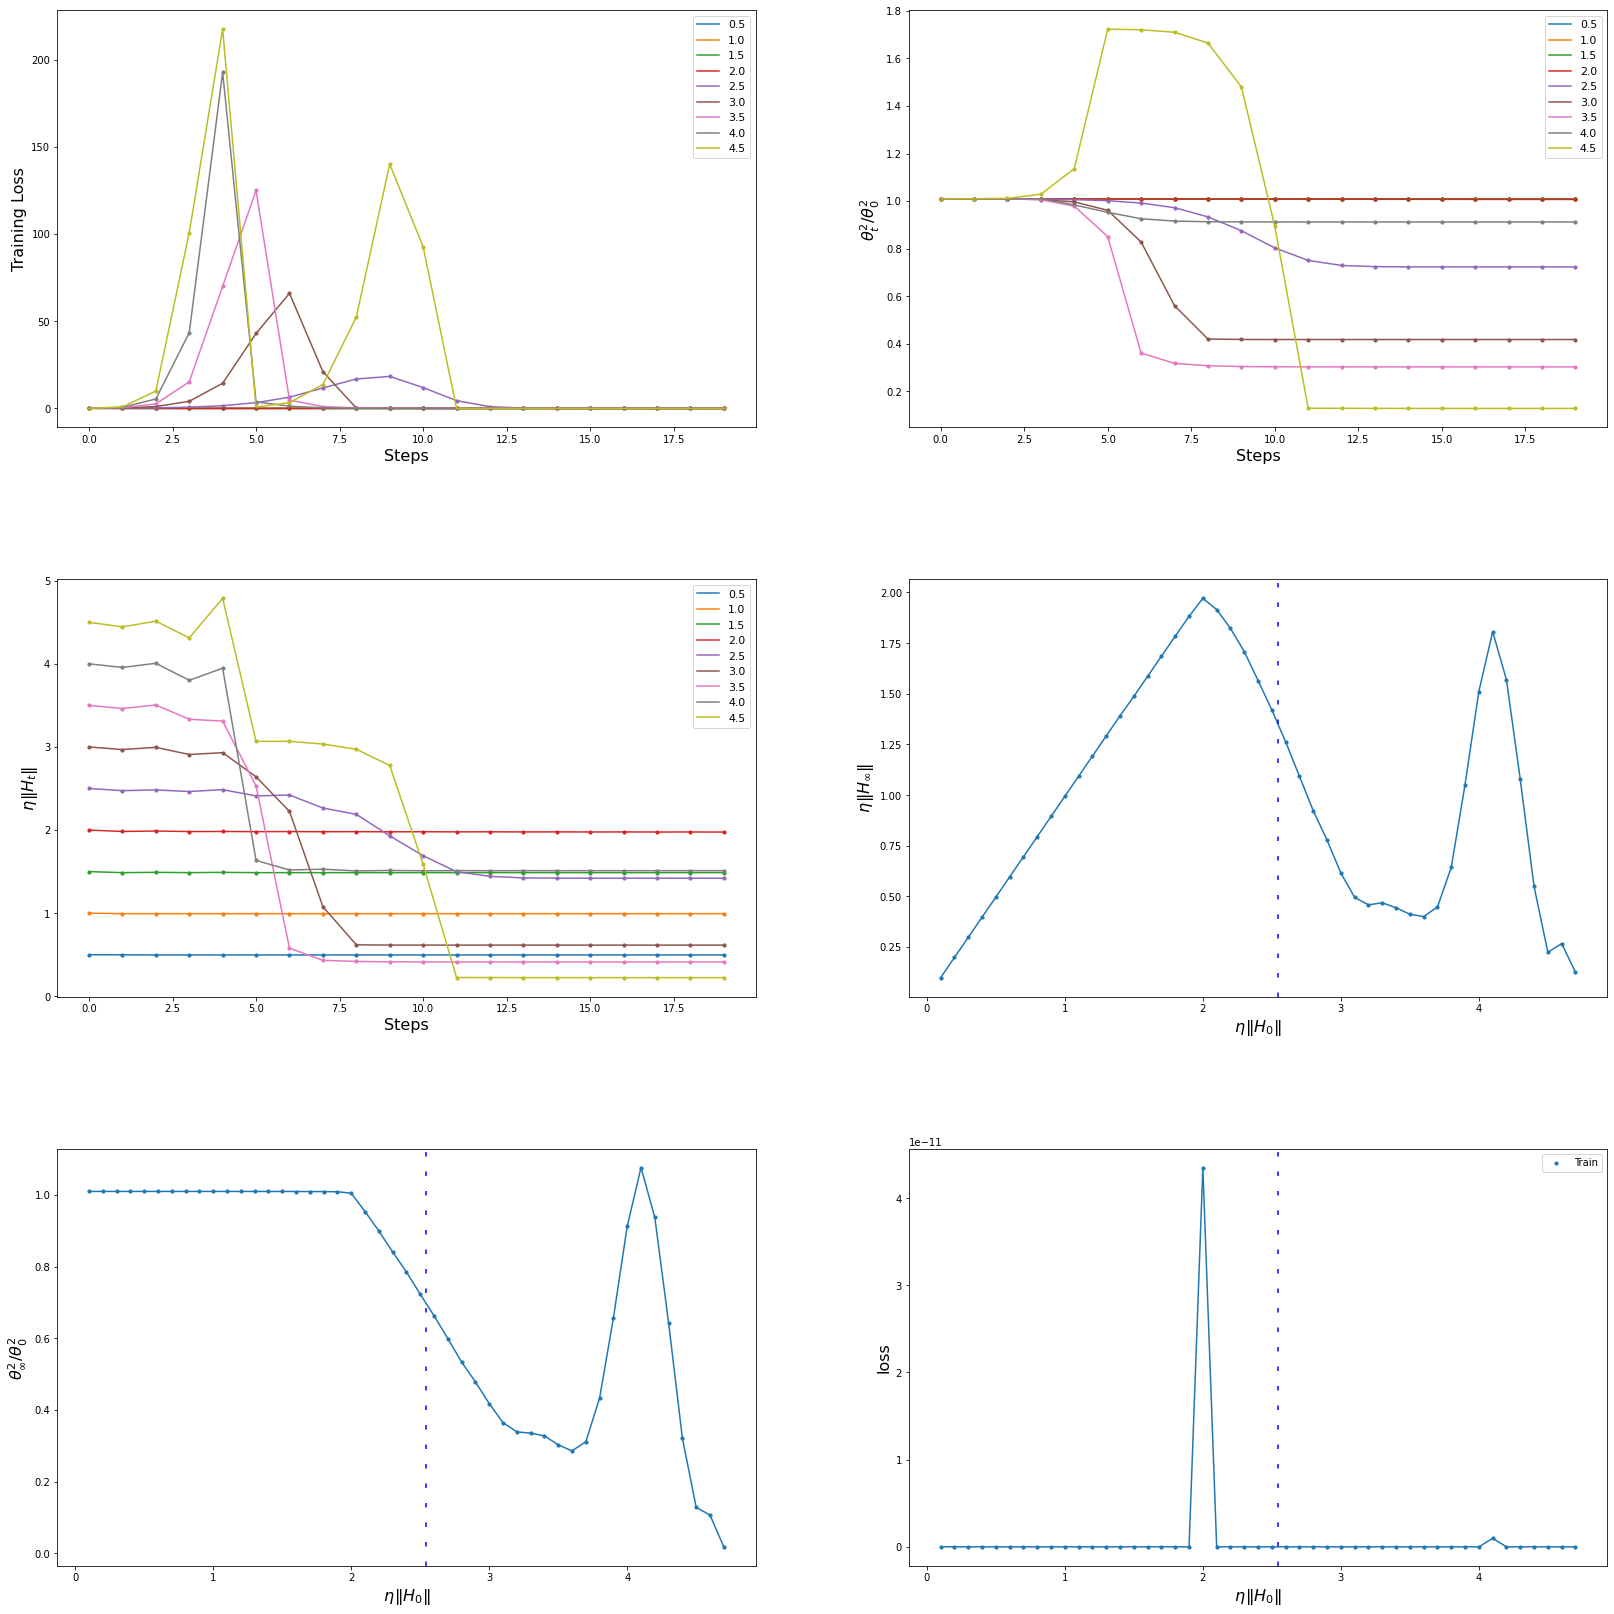

In [ ]:
arch=MLPGeneral

model_dict={}
model_dict['input_size']=1
# Width of the hidden layer
model_dict['width']=1024
#Activation function used in hidden layer
model_dict['activation']='leaky_relu'
# Number of hidden layers
model_dict['num_hidden_layers']=1
# If true, include bias vectors in linear layers.
model_dict['bias_value']=False

train_batch_size=1

lr_ratios=list(map(lambda x: np.round(x,2),list(np.arange(0.1,6+.1,.1))))

max_epochs=1000
stop_criterion=0

seed=120

#Slope of leaky_relu in negative region.
model_dict['slope']=.5

dataset={}
dataset['name']='toy_example'
dataset['train']=CustomDataset(list(zip(torch.tensor([[1.0]]),torch.tensor([[0.0]]))))

result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None,
                    device=device,
                    seed=seed,
                    printevery=250,
                    verbose=True,
                    write_file=save_files,
                    overwrite=False,
                    data_eigen=False)

produce_plots(result,
              xmin=0,
              xmax=20,
              include_predictions=True,
              mult_data=False,
              s=10,
              size=(25,25),
              offset=4,
              skip=5)

## Figure 3: ReLU, Two-Layers, Two-Class MNIST.

computing averaged top eigenvalues and eigenvectors
[batch/total:  1/128]

Training at lr_ratio: 0.5
epoch/total: 0/100000, train loss: 0.5864115953445435, NTK: 0.4987748834405329
epoch/total: 1000/100000, train loss: 0.0010944057721645, NTK: 0.5653545071027197
epoch/total: 2000/100000, train loss: 0.0002771281870082, NTK: 0.5754202696685708
epoch/total: 3000/100000, train loss: 0.0001140493695857, NTK: 0.5780917775240685
epoch/total: 4000/100000, train loss: 0.0000555788901693, NTK: 0.5799648834021681
epoch/total: 5000/100000, train loss: 0.0000300190295093, NTK: 0.5812847836325752
Partition train, batch/total 0/1
Partition test, batch/total 0/17

Training at lr_ratio: 1.0
epoch/total: 0/100000, train loss: 0.5864115953445435, NTK: 0.9977315108088365
epoch/total: 1000/100000, train loss: 0.0002779044152703, NTK: 1.1463117604946023
epoch/total: 2000/100000, train loss: 0.0000556825616513, NTK: 1.1570897170323775
epoch/total: 3000/100000, train loss: 0.0000172375293914, NTK: 1.160869479

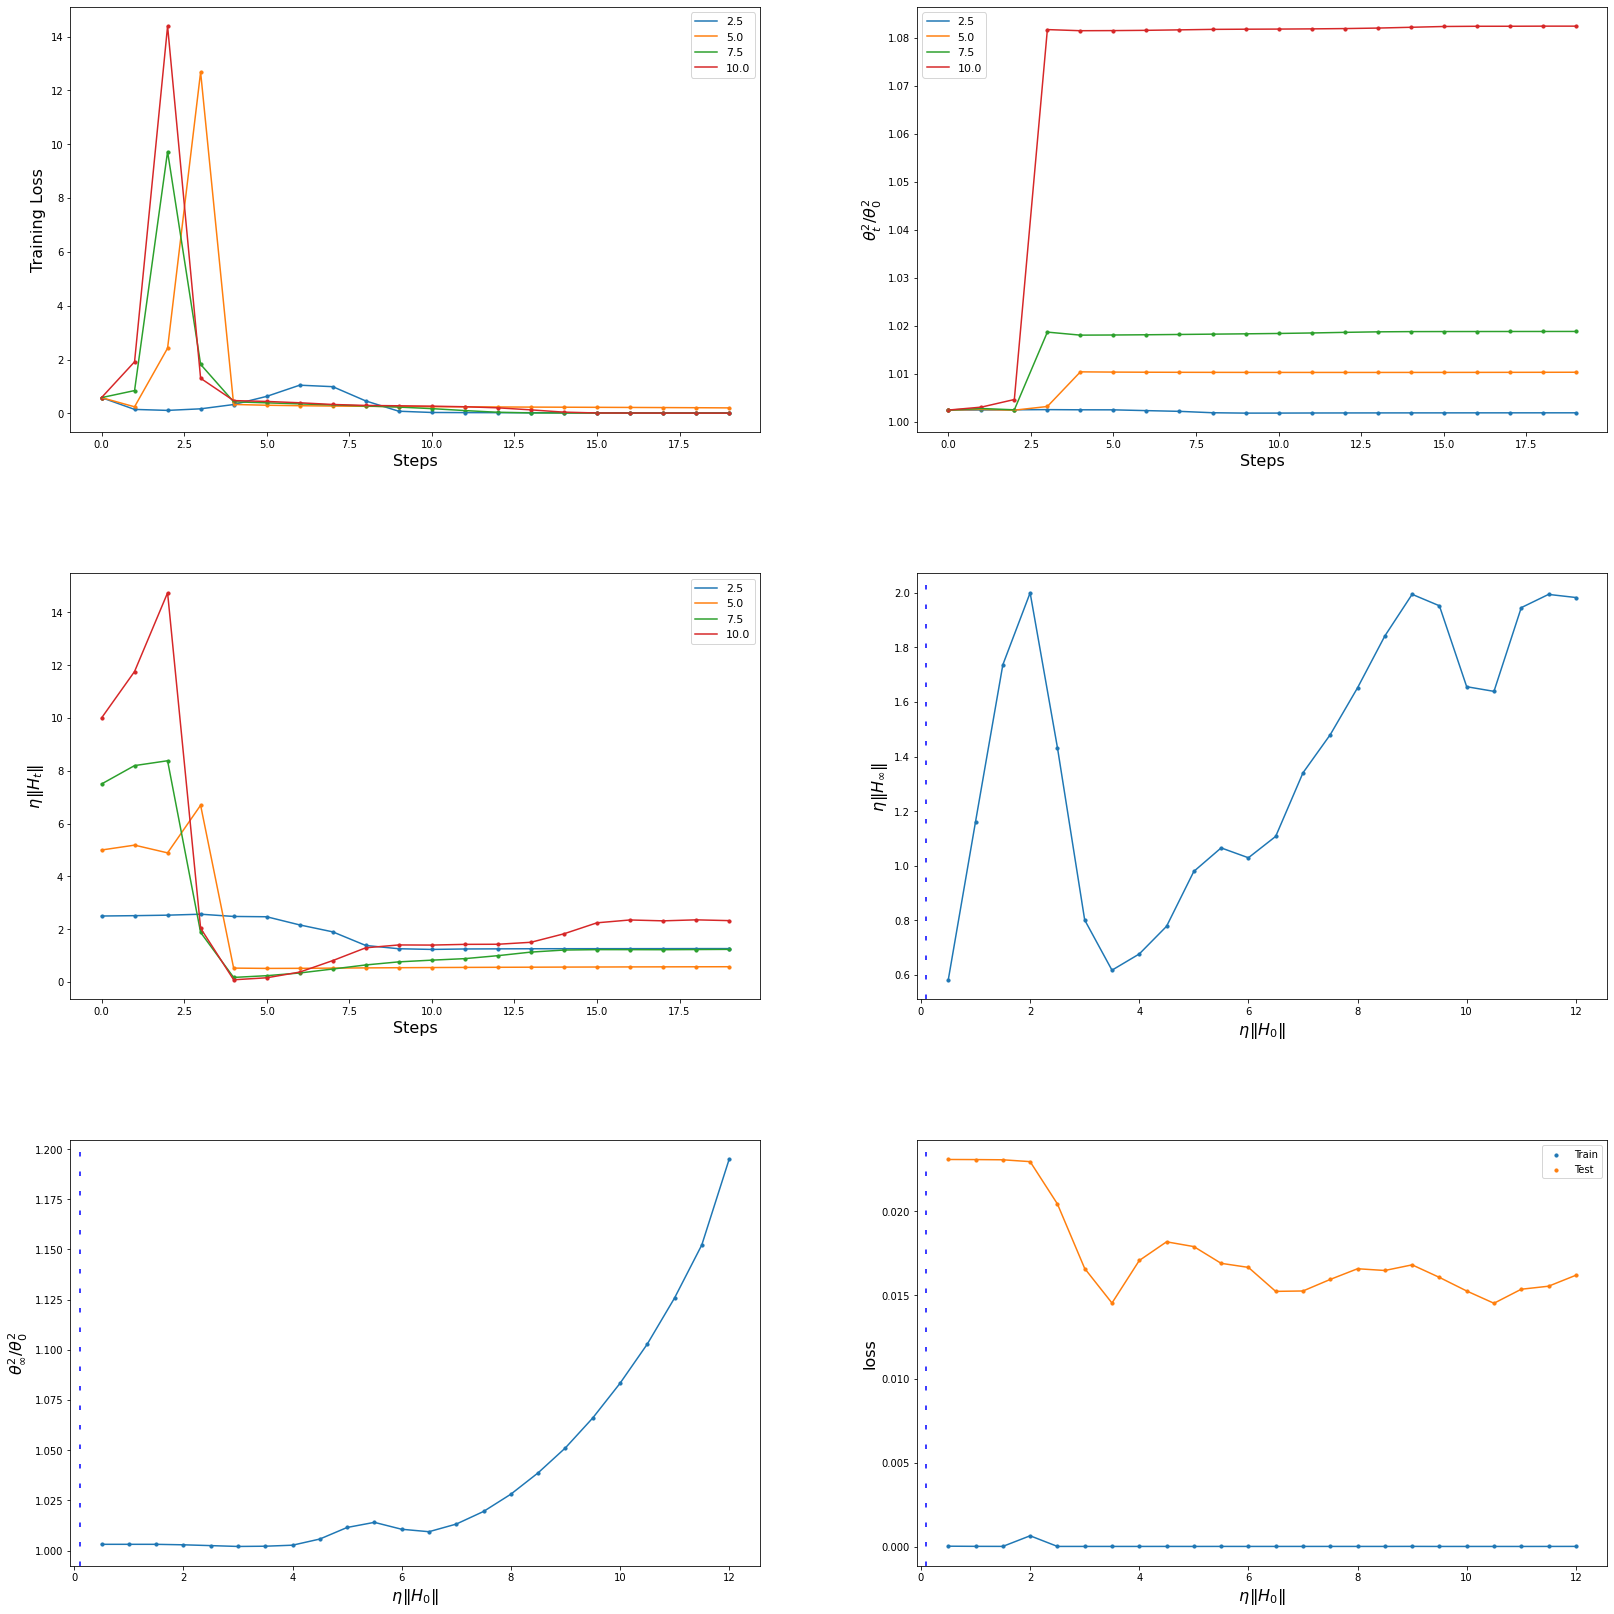

In [ ]:
arch=MLPGeneral

model_dict={}
model_dict['input_size']=28**2
model_dict['width']=1024
model_dict['activation']='relu'
model_dict['num_hidden_layers']=1
model_dict['bias_value']=False

dataset={}
dataset['name']='MNIST01_small'
dataset['train']=data['MNIST01_small','train']
dataset['test']=data['MNIST01_small','test']
train_batch_size=len(dataset['train'])

lr_ratios=np.arange(0.5,12+.5,.5)
max_epochs=100000
stop_criterion=10**-8

seed=123

result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None,
                    device=device,
                    seed=seed,
                    printevery=1000,
                    verbose=True,
                    write_file=save_files,
                    overwrite=True,
                    data_eigen=False)

produce_plots(result,
              xmin=0,
              xmax=20,
              include_predictions=True,
              mult_data=False,
              s=10,
              size=(25,25),
              offset=4,
              skip=5)

## Figure 4: Pure Quadratic, random 2d data

computing averaged top eigenvalues and eigenvectors
[batch/total:  1/32]

Training at lr_ratio: 0.1
epoch/total: 0/100, train loss: 0.6680623292922974, lrNTK: 0.0999602805704908

Training at lr_ratio: 0.2
epoch/total: 0/100, train loss: 0.6680623292922974, lrNTK: 0.1998518177787571

Training at lr_ratio: 0.3
epoch/total: 0/100, train loss: 0.6680623292922974, lrNTK: 0.2996904940354511

Training at lr_ratio: 0.4
epoch/total: 0/100, train loss: 0.6680623292922974, lrNTK: 0.3994921381397127

Training at lr_ratio: 0.5
epoch/total: 0/100, train loss: 0.6680623292922974, lrNTK: 0.4992727263223414

Training at lr_ratio: 0.6
epoch/total: 0/100, train loss: 0.6680623292922974, lrNTK: 0.5990484224544315

Training at lr_ratio: 0.7
epoch/total: 0/100, train loss: 0.6680623292922974, lrNTK: 0.6988344253998480

Training at lr_ratio: 0.8
epoch/total: 0/100, train loss: 0.6680623292922974, lrNTK: 0.7986475959793511

Training at lr_ratio: 0.9
epoch/total: 0/100, train loss: 0.6680623292922974, lrNTK: 0

/content/drive/MyDrive/catapult_clean/training.py:58: RuntimeWarning: overflow encountered in square
  result+=np.sum(e.detach().cpu().numpy()**2)


model diverges


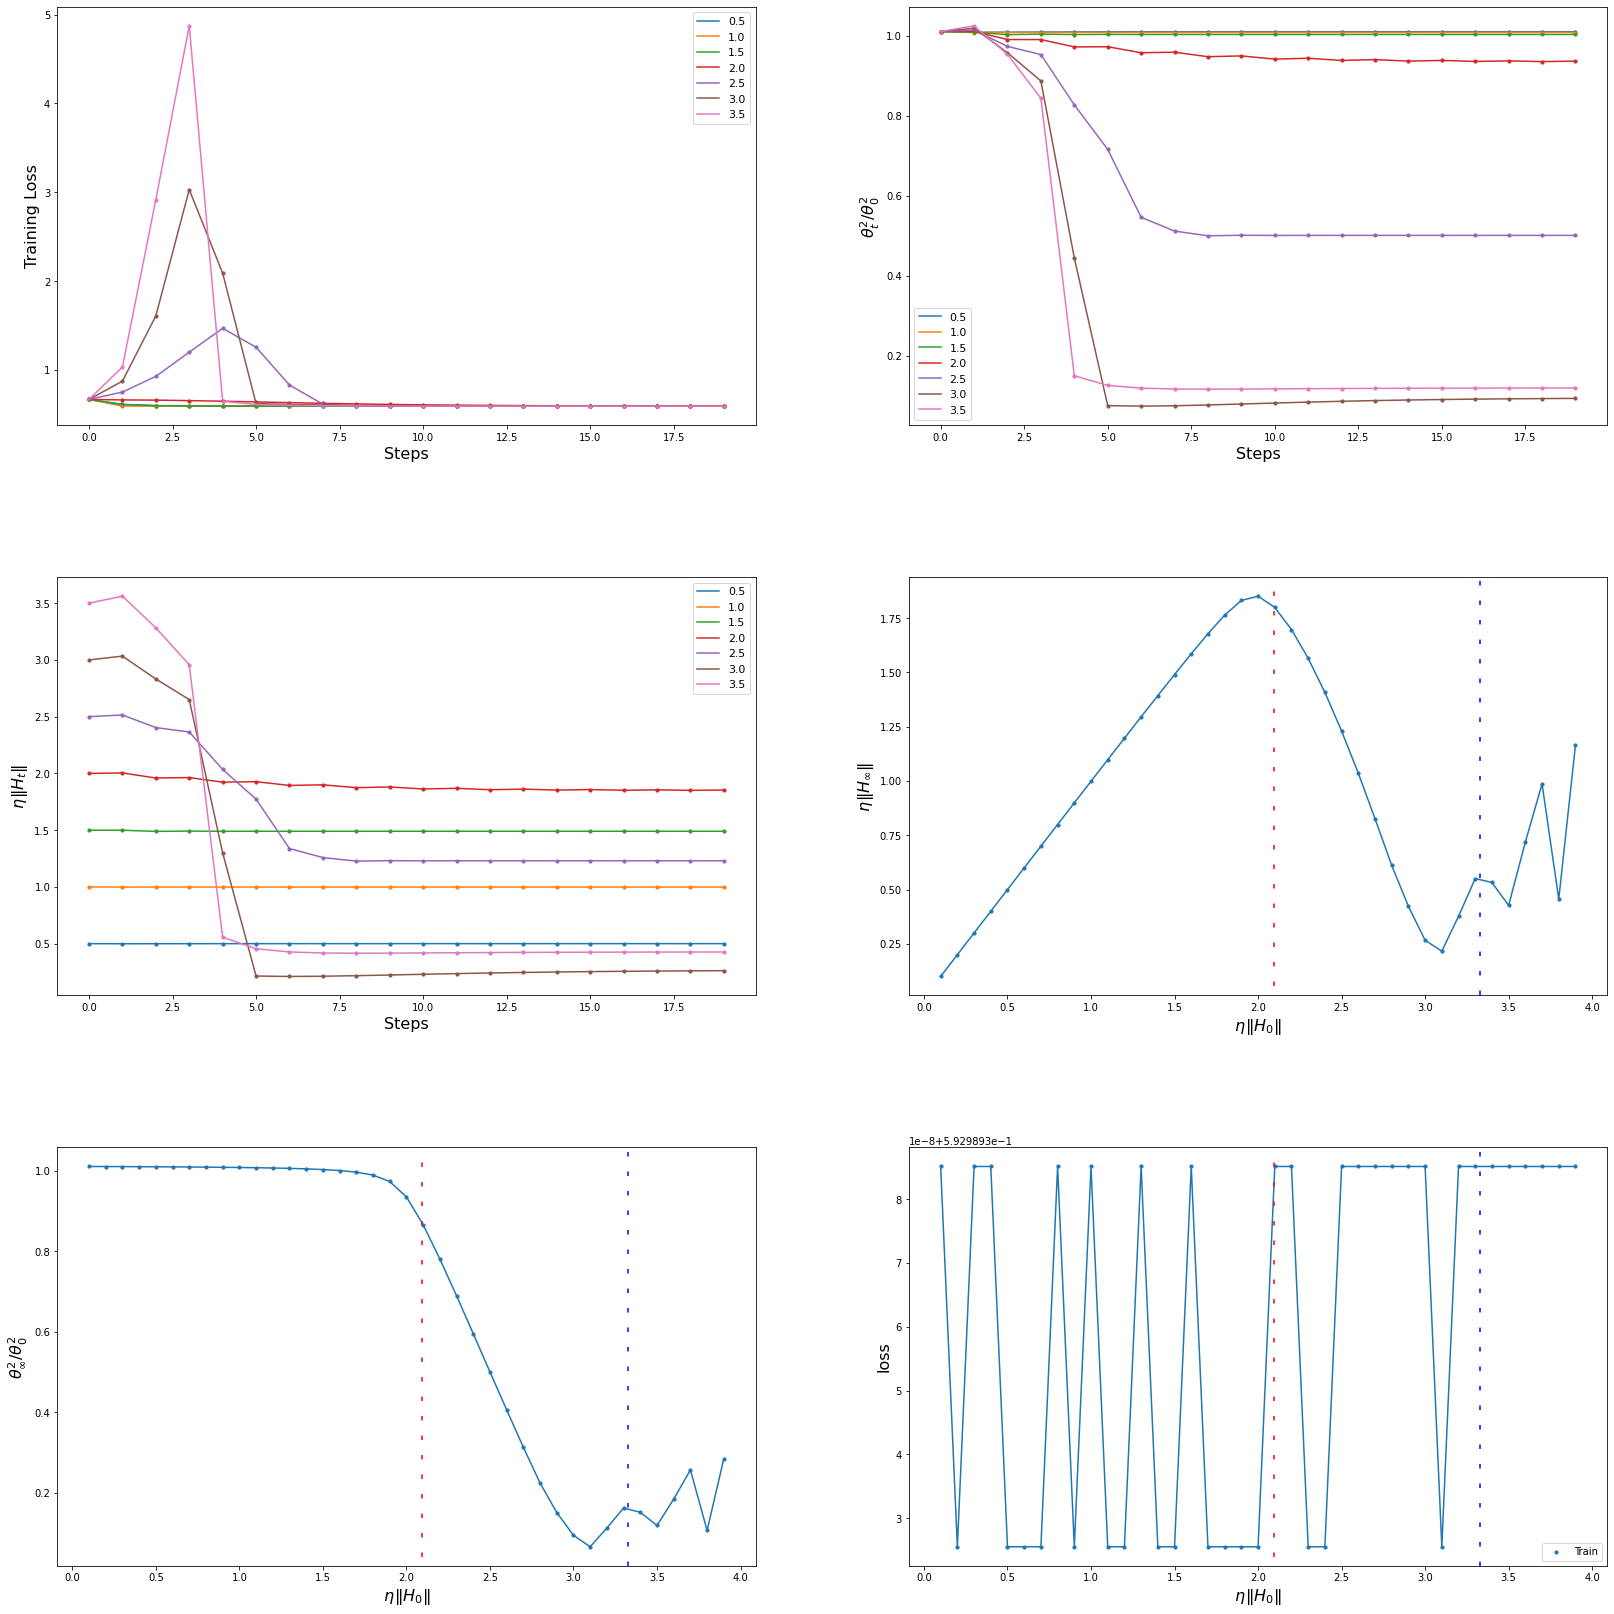

In [ ]:
model_dict={}

num_train_samps=32
num_test_samps=512

model_dict['input_dim']=2
model_dict['hidden_dim']=500
train_batch_size=32

model_dict['act']='identity'
 
eval_dist={}
eval_dist['dist']='uniform'
eval_dist['params']=(.9,1.1)
model_dict['eval_dist']=eval_dist

matrix_dist={}
matrix_dist['dist']='normal'
matrix_dist['params']=(0,1)
model_dict['matrix_dist']=matrix_dist

lr_ratios=list(map(lambda x:round(x,2),np.arange(.1,4+.1,.1)))

dataset={}
dataset['name']='random'
arch=Quadratic
model_dict['device']=device

seed=120
torch.manual_seed(seed)

max_epochs=100
stop_criterion=0

X_train=(torch.rand((num_train_samps,model_dict['input_dim']))-1/2)
y_train=torch.randn((num_train_samps,1))
dataset['train']=CustomDataset(list(zip(X_train,y_train)))

#X_test=(torch.rand((num_test_samps,model_dict['input_dim']))-1/2)
#y_test=torch.randn((num_test_samps,1))

result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None,
                    device=device,
                    seed=seed,
                    printevery=250,
                    verbose=True,
                    write_file=save_files,
                    overwrite=True,
                    data_eigen=False)

produce_plots(result,
              xmin=0,
              xmax=20,
              include_predictions=True,
              mult_data=True,
              s=10,
              size=(25,25),
              offset=4,
              skip=5)

## Figure 5: Pure quadratic, teacher student

computing averaged top eigenvalues and eigenvectors
eigenvalues already computed

Training at lr_ratio: 0.1
training already done

Training at lr_ratio: 0.2
training already done

Training at lr_ratio: 0.3
training already done

Training at lr_ratio: 0.4
training already done

Training at lr_ratio: 0.5
training already done

Training at lr_ratio: 0.6
training already done

Training at lr_ratio: 0.7
training already done

Training at lr_ratio: 0.8
training already done

Training at lr_ratio: 0.9
training already done

Training at lr_ratio: 1.0
training already done

Training at lr_ratio: 1.1
training already done

Training at lr_ratio: 1.2
training already done

Training at lr_ratio: 1.3
training already done

Training at lr_ratio: 1.4
training already done

Training at lr_ratio: 1.5
training already done

Training at lr_ratio: 1.6
training already done

Training at lr_ratio: 1.7
training already done

Training at lr_ratio: 1.8
training already done

Training at lr_ratio: 1.9
training a

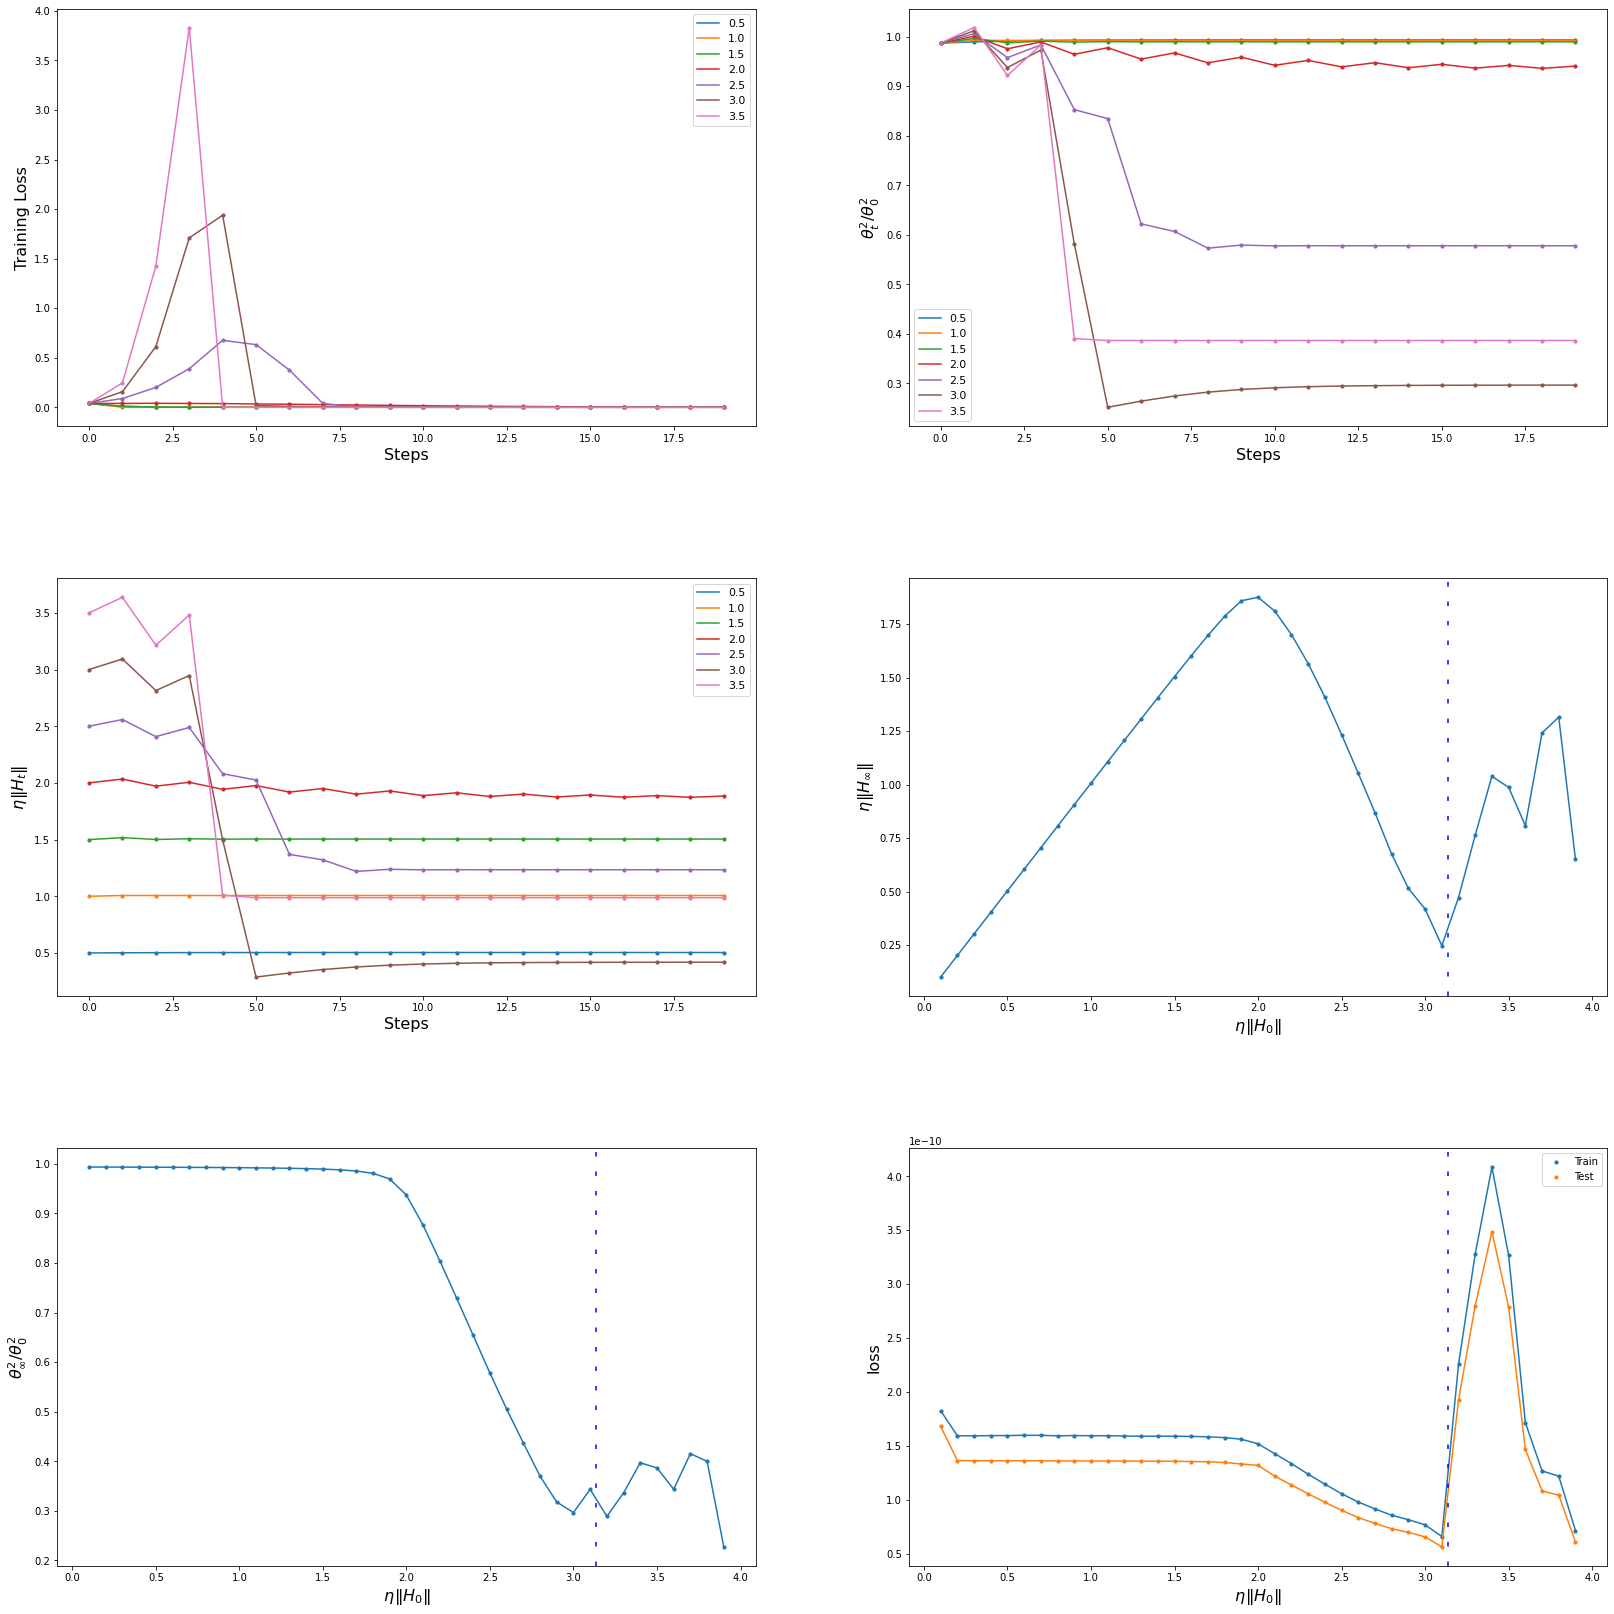

In [ ]:
model_dict={}
num_samps_train=32
num_samps_test=1000
model_dict['input_dim']=1
model_dict['hidden_dim']=500
model_dict['masks']=100

train_batch_size=32
 
eval_dist={}
eval_dist['dist']='uniform'
eval_dist['params']=(1,1)
model_dict['eval_dist']=eval_dist
model_dict['act']='tanh'

matrix_dist={}
matrix_dist['dist']='normal'
matrix_dist['params']=(0,1)
model_dict['matrix_dist']=matrix_dist

seed=120

torch.manual_seed(seed)
dataset={}
dataset['name']='teacher_student'
dataset['train']=(torch.rand((num_samps_train,model_dict['input_dim']))-1/2)
dataset['test']=(torch.rand((num_samps_test,model_dict['input_dim']))-1/2)
arch=Quadratic
model_dict['device']=device

lr_ratios=list(map(lambda x: np.round(x,3),np.arange(.1,4+.1,.1)))
max_epochs=100
stop_criterion=0

result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None,
                    device=device,
                    seed=seed,
                    printevery=250,
                    verbose=True,
                    write_file=save_files,
                    overwrite=False,
                    data_eigen=False)

produce_plots(result,
              xmin=0,
              xmax=20,
              include_predictions=True,
              mult_data=False,
              s=10,
              size=(25,25),
              offset=4,
              skip=5)

## Figure 6: Quadratic with bias, toy dataset

computing averaged top eigenvalues and eigenvectors
eigenvalues already computed

Training at lr_ratio: 0.1
training already done

Training at lr_ratio: 0.2
training already done

Training at lr_ratio: 0.3
training already done

Training at lr_ratio: 0.4
training already done

Training at lr_ratio: 0.5
training already done

Training at lr_ratio: 0.6
training already done

Training at lr_ratio: 0.7
training already done

Training at lr_ratio: 0.8
training already done

Training at lr_ratio: 0.9
training already done

Training at lr_ratio: 1.0
training already done

Training at lr_ratio: 1.1
training already done

Training at lr_ratio: 1.2
training already done

Training at lr_ratio: 1.3
training already done

Training at lr_ratio: 1.4
training already done

Training at lr_ratio: 1.5
training already done

Training at lr_ratio: 1.6
training already done

Training at lr_ratio: 1.7
training already done

Training at lr_ratio: 1.8
training already done

Training at lr_ratio: 1.9
training a

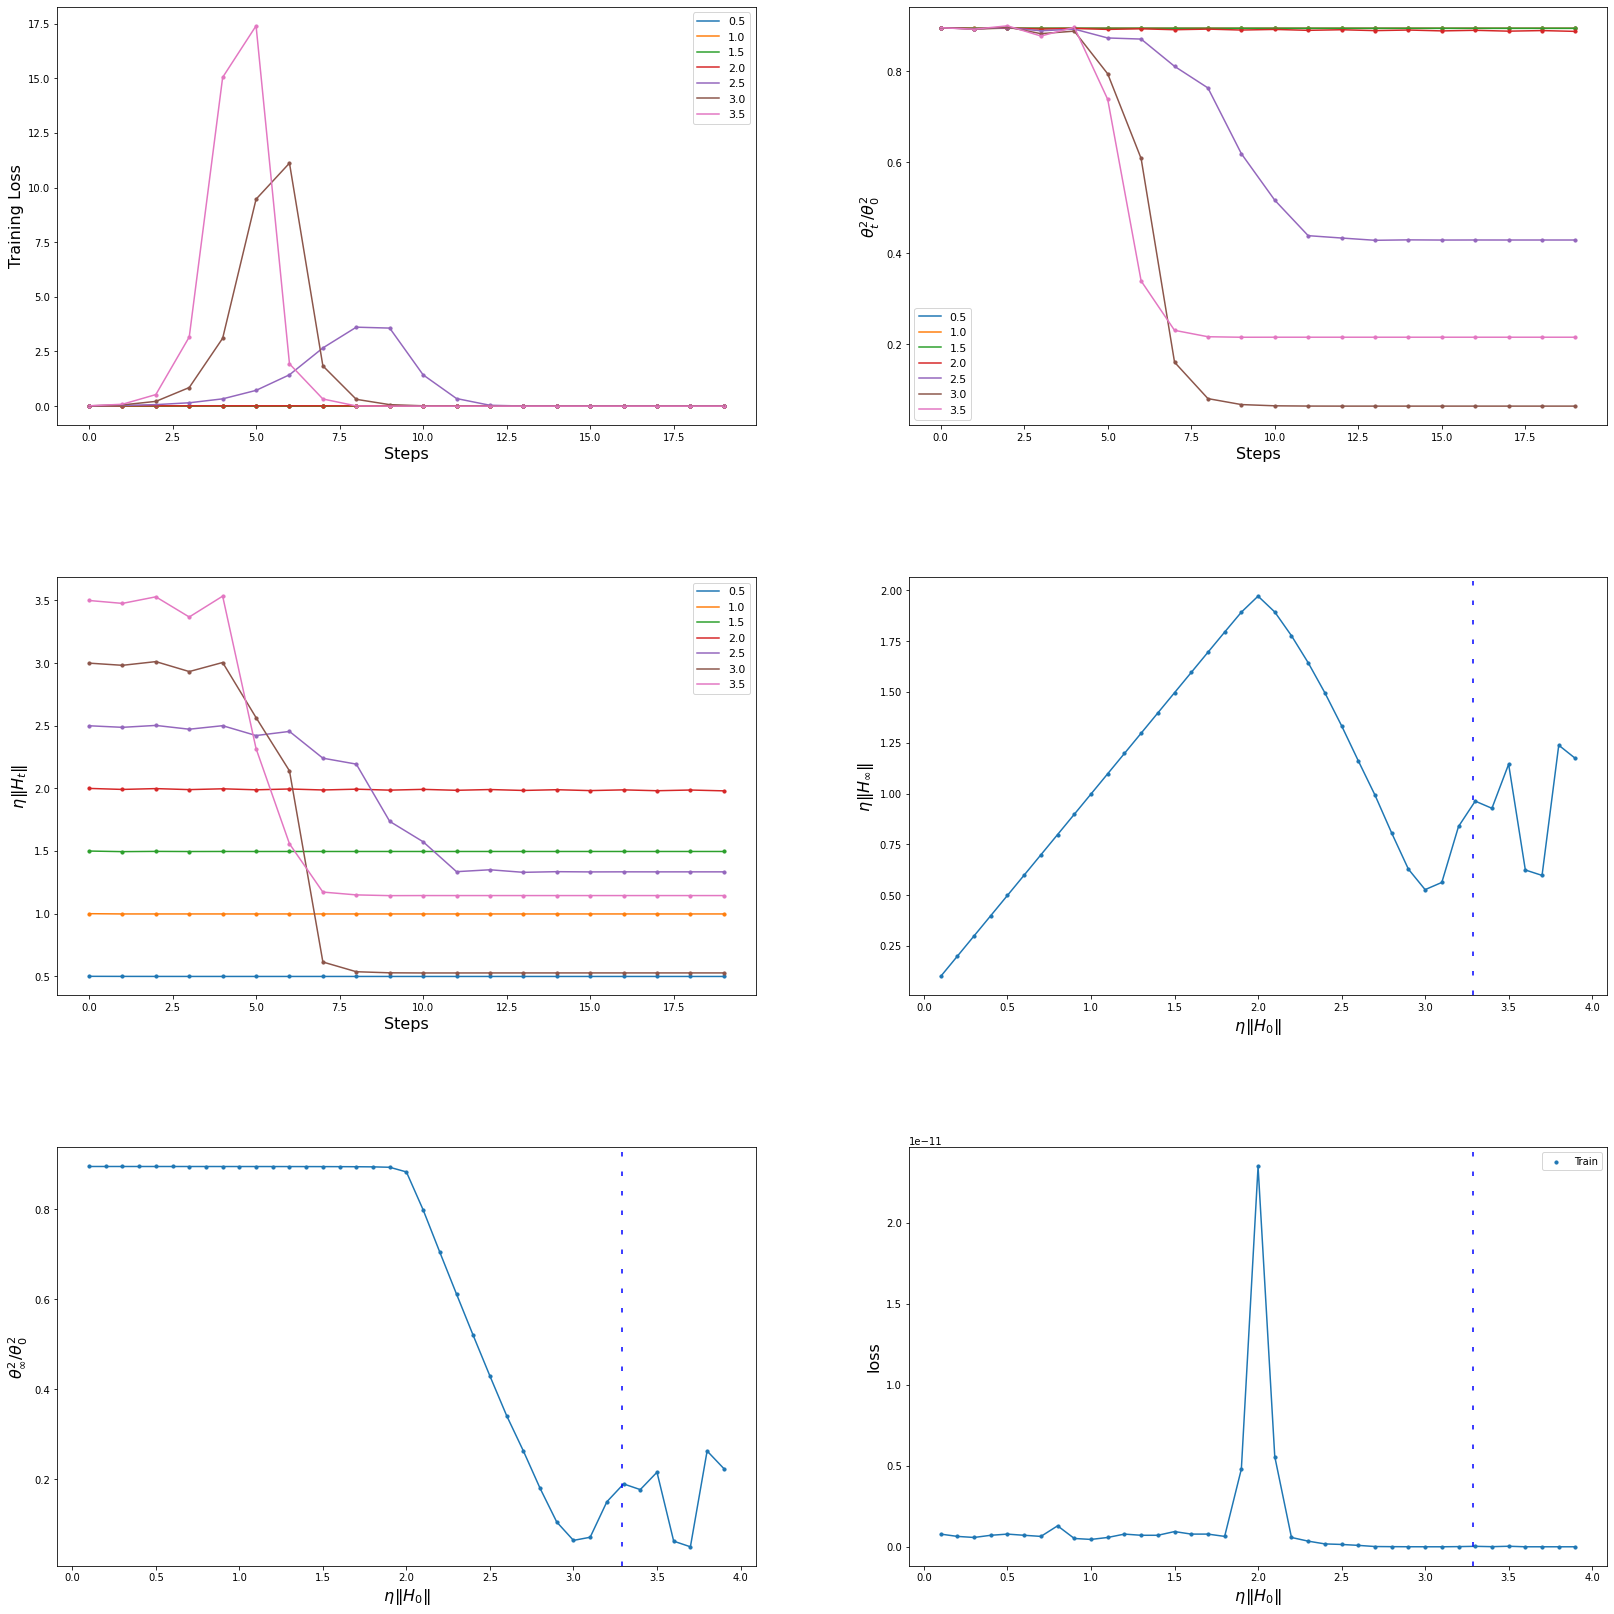

In [ ]:
model_dict={}
model_dict['input_dim']=1
model_dict['feat_dim']=10
model_dict['meta_dim']=100
model_dict['device']=device
train_batch_size=1
seed=123

eval_dist={}
eval_dist['dist']='uniform'
eval_dist['params']=(1,1)
model_dict['eval_dist']=eval_dist

matrix_dist={}
matrix_dist['dist']='normal'
matrix_dist['params']=(0,1)
model_dict['matrix_dist']=matrix_dist

dataset={}
dataset['name']='toy_example'
dataset['train']=CustomDataset(list(zip(torch.tensor([[1.0]]),torch.tensor([[0.0]]))))


arch=quadratic_with_bias

lr_ratios=list(map(lambda x: np.round(x,2),list(np.arange(0.1,4+.1,.1))))

max_epochs=1000
stop_criterion=0

result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None,
                    device=device,
                    seed=seed,
                    printevery=250,
                    verbose=True,
                    write_file=save_files,
                    overwrite=False,
                    data_eigen=False)

produce_plots(result,
              xmin=0,
              xmax=20,
              include_predictions=True,
              mult_data=False,
              s=10,
              size=(25,25),
              offset=4,
              skip=5)

## Figure 7: Quadratic with bias, teacher-student

computing averaged top eigenvalues and eigenvectors
eigenvalues already computed

Training at lr_ratio: 0.1
training already done

Training at lr_ratio: 0.2
training already done

Training at lr_ratio: 0.3
training already done

Training at lr_ratio: 0.4
training already done

Training at lr_ratio: 0.5
training already done

Training at lr_ratio: 0.6
training already done

Training at lr_ratio: 0.7
training already done

Training at lr_ratio: 0.8
training already done

Training at lr_ratio: 0.9
training already done

Training at lr_ratio: 1.0
training already done

Training at lr_ratio: 1.1
training already done

Training at lr_ratio: 1.2
training already done

Training at lr_ratio: 1.3
training already done

Training at lr_ratio: 1.4
training already done

Training at lr_ratio: 1.5
training already done

Training at lr_ratio: 1.6
training already done

Training at lr_ratio: 1.7
training already done

Training at lr_ratio: 1.8
training already done

Training at lr_ratio: 1.9
training a

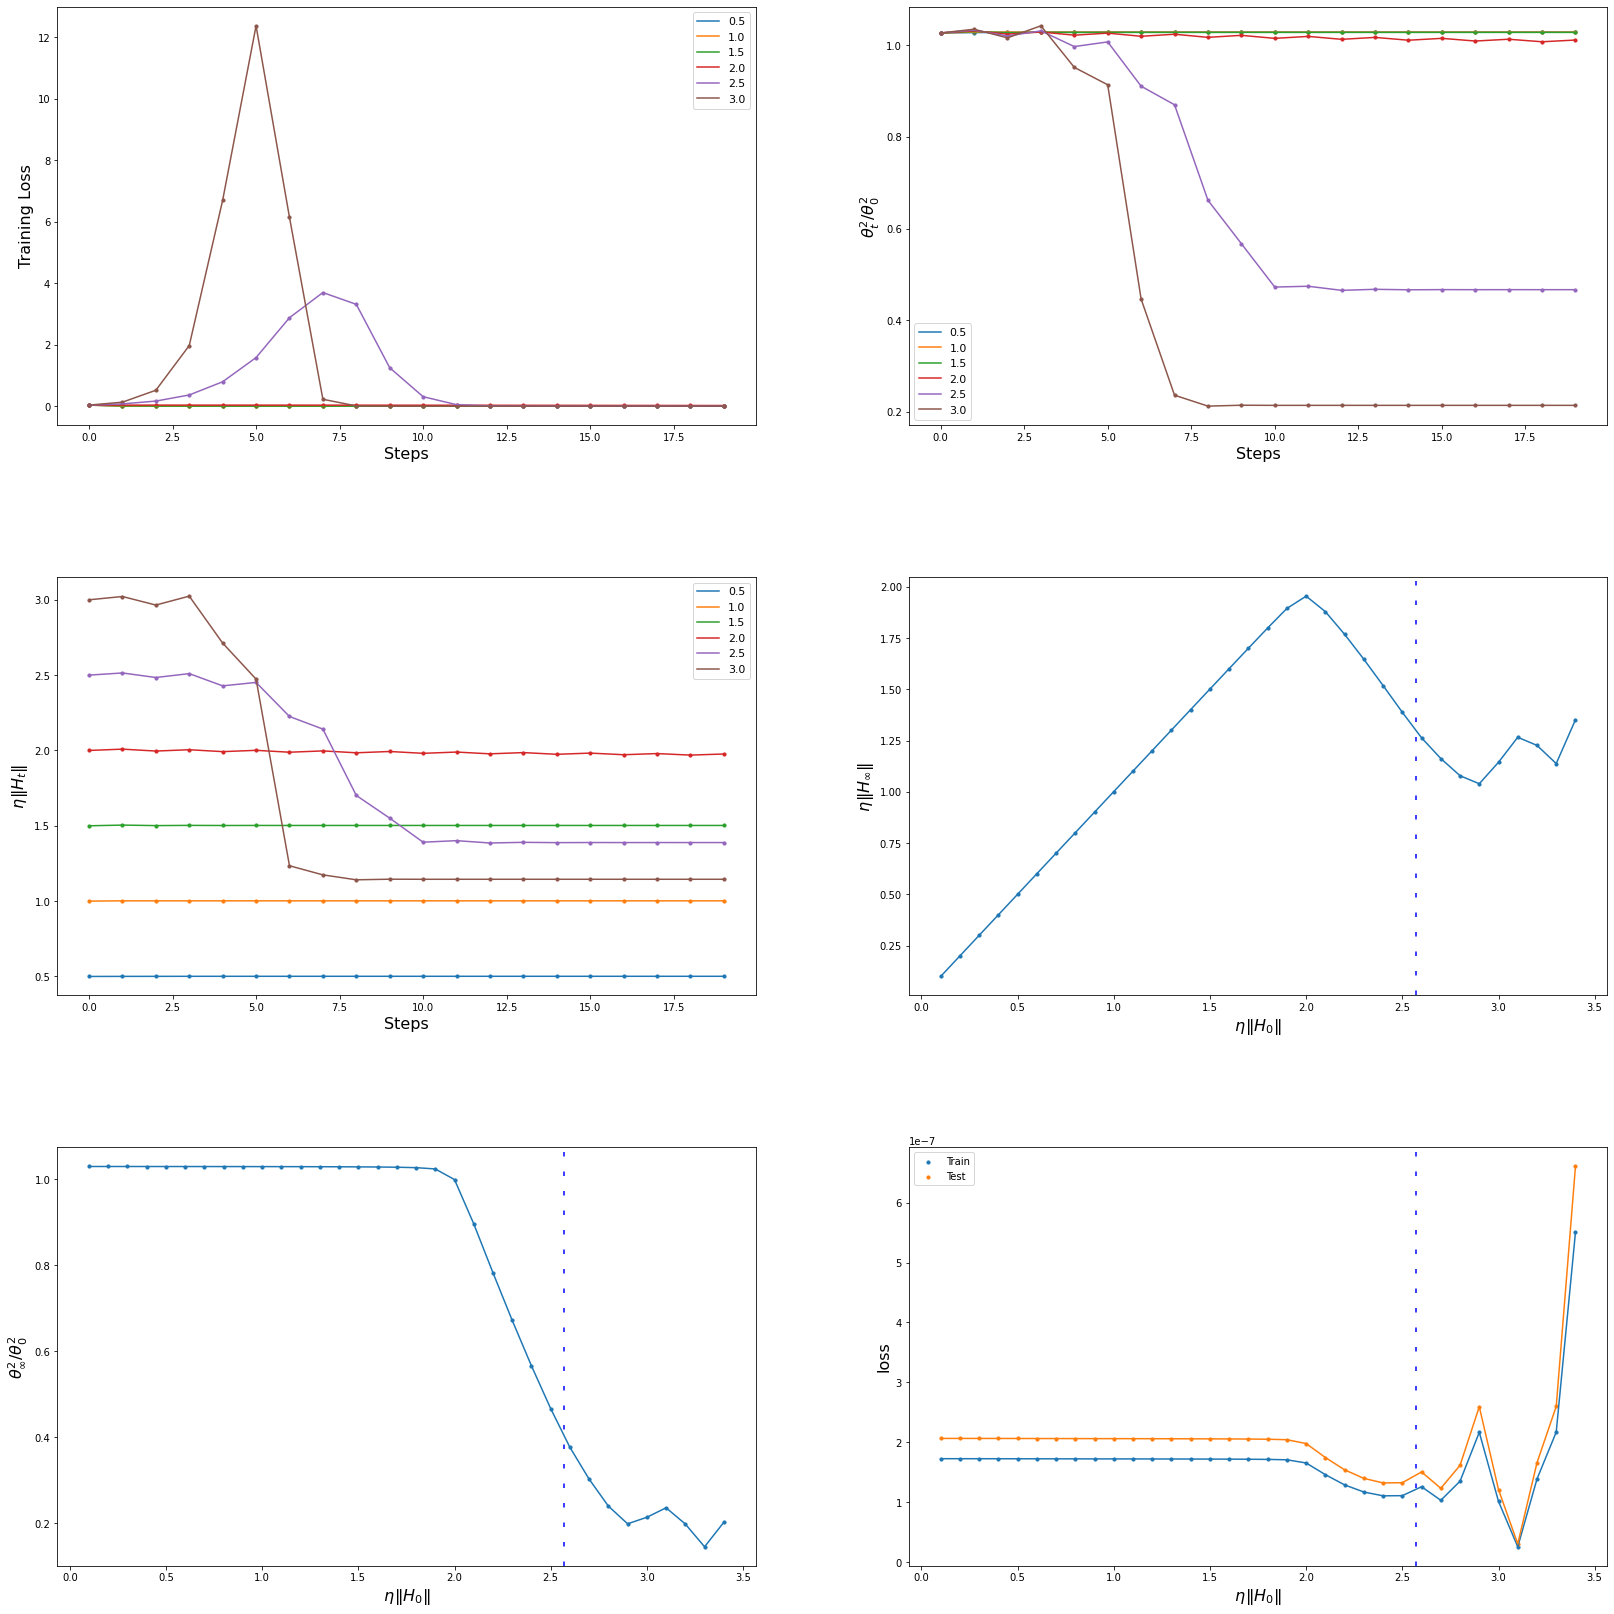

In [ ]:
model_dict={}
model_dict['input_dim']=1

model_dict['feat_dim']=20
model_dict['masked_feats']=10

model_dict['meta_dim']=200
model_dict['masks_metafeats']=50
model_dict['act_name']='tanh'

seed=123
torch.manual_seed(seed)
eval_dist={}
eval_dist['dist']='uniform'
eval_dist['params']=(1,1)
model_dict['eval_dist']=eval_dist

matrix_dist={}
matrix_dist['dist']='normal'
matrix_dist['params']=(0,1)
model_dict['matrix_dist']=matrix_dist

num_samps_train=32
num_samps_test=2000

train_batch_size=num_samps_train
dataset={}
dataset['name']='st'
dataset['train']=2*(torch.rand((num_samps_train,model_dict['input_dim']))-1/2)
dataset['test']=2*(torch.rand((num_samps_test,model_dict['input_dim']))-1/2)

arch=quadratic_with_bias

lr_ratios=list(map(lambda x: np.round(x,2),list(np.arange(0.1,4+.1,.1))))

max_epochs=1000
stop_criterion=0

result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None,
                    device=device,
                    seed=seed,
                    printevery=250,
                    verbose=True,
                    write_file=save_files,
                    overwrite=False,
                    data_eigen=False)

produce_plots(result,
              xmin=0,
              xmax=20,
              include_predictions=True,
              mult_data=False,
              s=10,
              size=(25,25),
              offset=4,
              skip=5)

## Figure 8: Scale-Invariant (slope 3/4), Two-Layer, Toy dataset

computing averaged top eigenvalues and eigenvectors
eigenvalues already computed

Training at lr_ratio: 0.1
training already done

Training at lr_ratio: 0.2
training already done

Training at lr_ratio: 0.3
training already done

Training at lr_ratio: 0.4
training already done

Training at lr_ratio: 0.5
training already done

Training at lr_ratio: 0.6
training already done

Training at lr_ratio: 0.7
training already done

Training at lr_ratio: 0.8
training already done

Training at lr_ratio: 0.9
training already done

Training at lr_ratio: 1.0
training already done

Training at lr_ratio: 1.1
training already done

Training at lr_ratio: 1.2
training already done

Training at lr_ratio: 1.3
training already done

Training at lr_ratio: 1.4
training already done

Training at lr_ratio: 1.5
training already done

Training at lr_ratio: 1.6
training already done

Training at lr_ratio: 1.7
training already done

Training at lr_ratio: 1.8
training already done

Training at lr_ratio: 1.9
training a

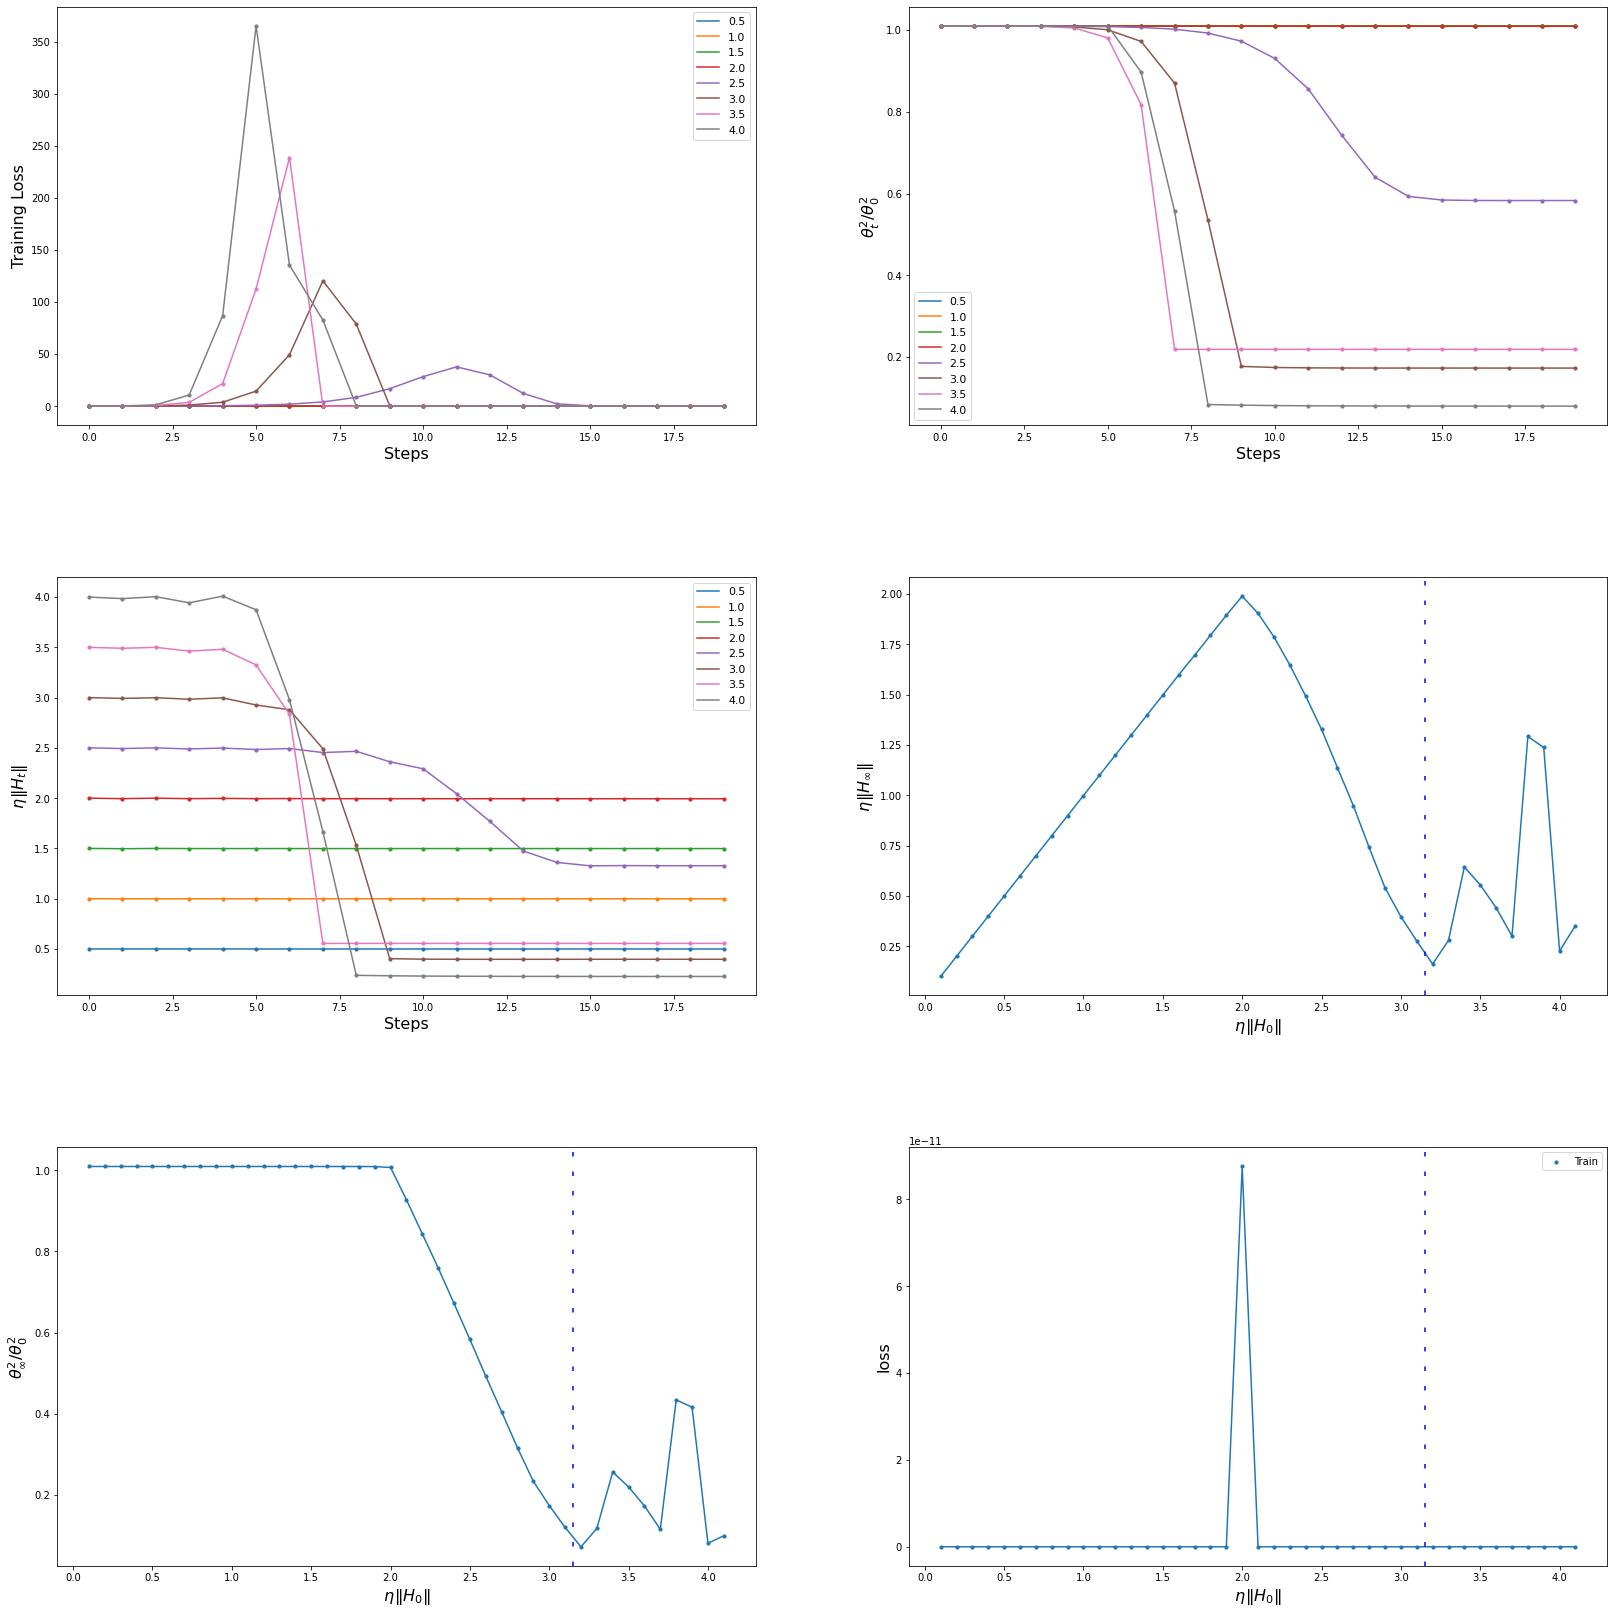

In [ ]:
arch=MLPGeneral

model_dict={}
model_dict['input_size']=1
model_dict['width']=1024
model_dict['activation']='leaky_relu'
model_dict['num_hidden_layers']=1
model_dict['bias_value']=False

train_batch_size=1

lr_ratios=list(map(lambda x: np.round(x,2),list(np.arange(0.1,6+.1,.1))))

max_epochs=1000
stop_criterion=0

seed=120

model_dict['slope']=.75
slope=np.round(.5,3)

dataset={}
dataset['name']='toy_example'
dataset['train']=CustomDataset(list(zip(torch.tensor([[1.0]]),torch.tensor([[0.0]]))))

result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None,
                    device=device,
                    seed=seed,
                    printevery=250,
                    verbose=True,
                    write_file=save_files,
                    overwrite=False,
                    data_eigen=False)

produce_plots(result,
              xmin=0,
              xmax=20,
              include_predictions=True,
              mult_data=False,
              s=10,
              size=(25,25),
              offset=4,
              skip=5)

## Figure 9: Scale-Invariant (slope 1/2), Two-Layer, Random data.

computing averaged top eigenvalues and eigenvectors
eigenvalues already computed

Training at lr_ratio: 0.1
training already done

Training at lr_ratio: 0.2
training already done

Training at lr_ratio: 0.3
training already done

Training at lr_ratio: 0.4
training already done

Training at lr_ratio: 0.5
training already done

Training at lr_ratio: 0.6
training already done

Training at lr_ratio: 0.7
training already done

Training at lr_ratio: 0.8
training already done

Training at lr_ratio: 0.9
training already done

Training at lr_ratio: 1.0
training already done

Training at lr_ratio: 1.1
training already done

Training at lr_ratio: 1.2
training already done

Training at lr_ratio: 1.3
training already done

Training at lr_ratio: 1.4
training already done

Training at lr_ratio: 1.5
training already done

Training at lr_ratio: 1.6
training already done

Training at lr_ratio: 1.7
training already done

Training at lr_ratio: 1.8
training already done

Training at lr_ratio: 1.9
training a

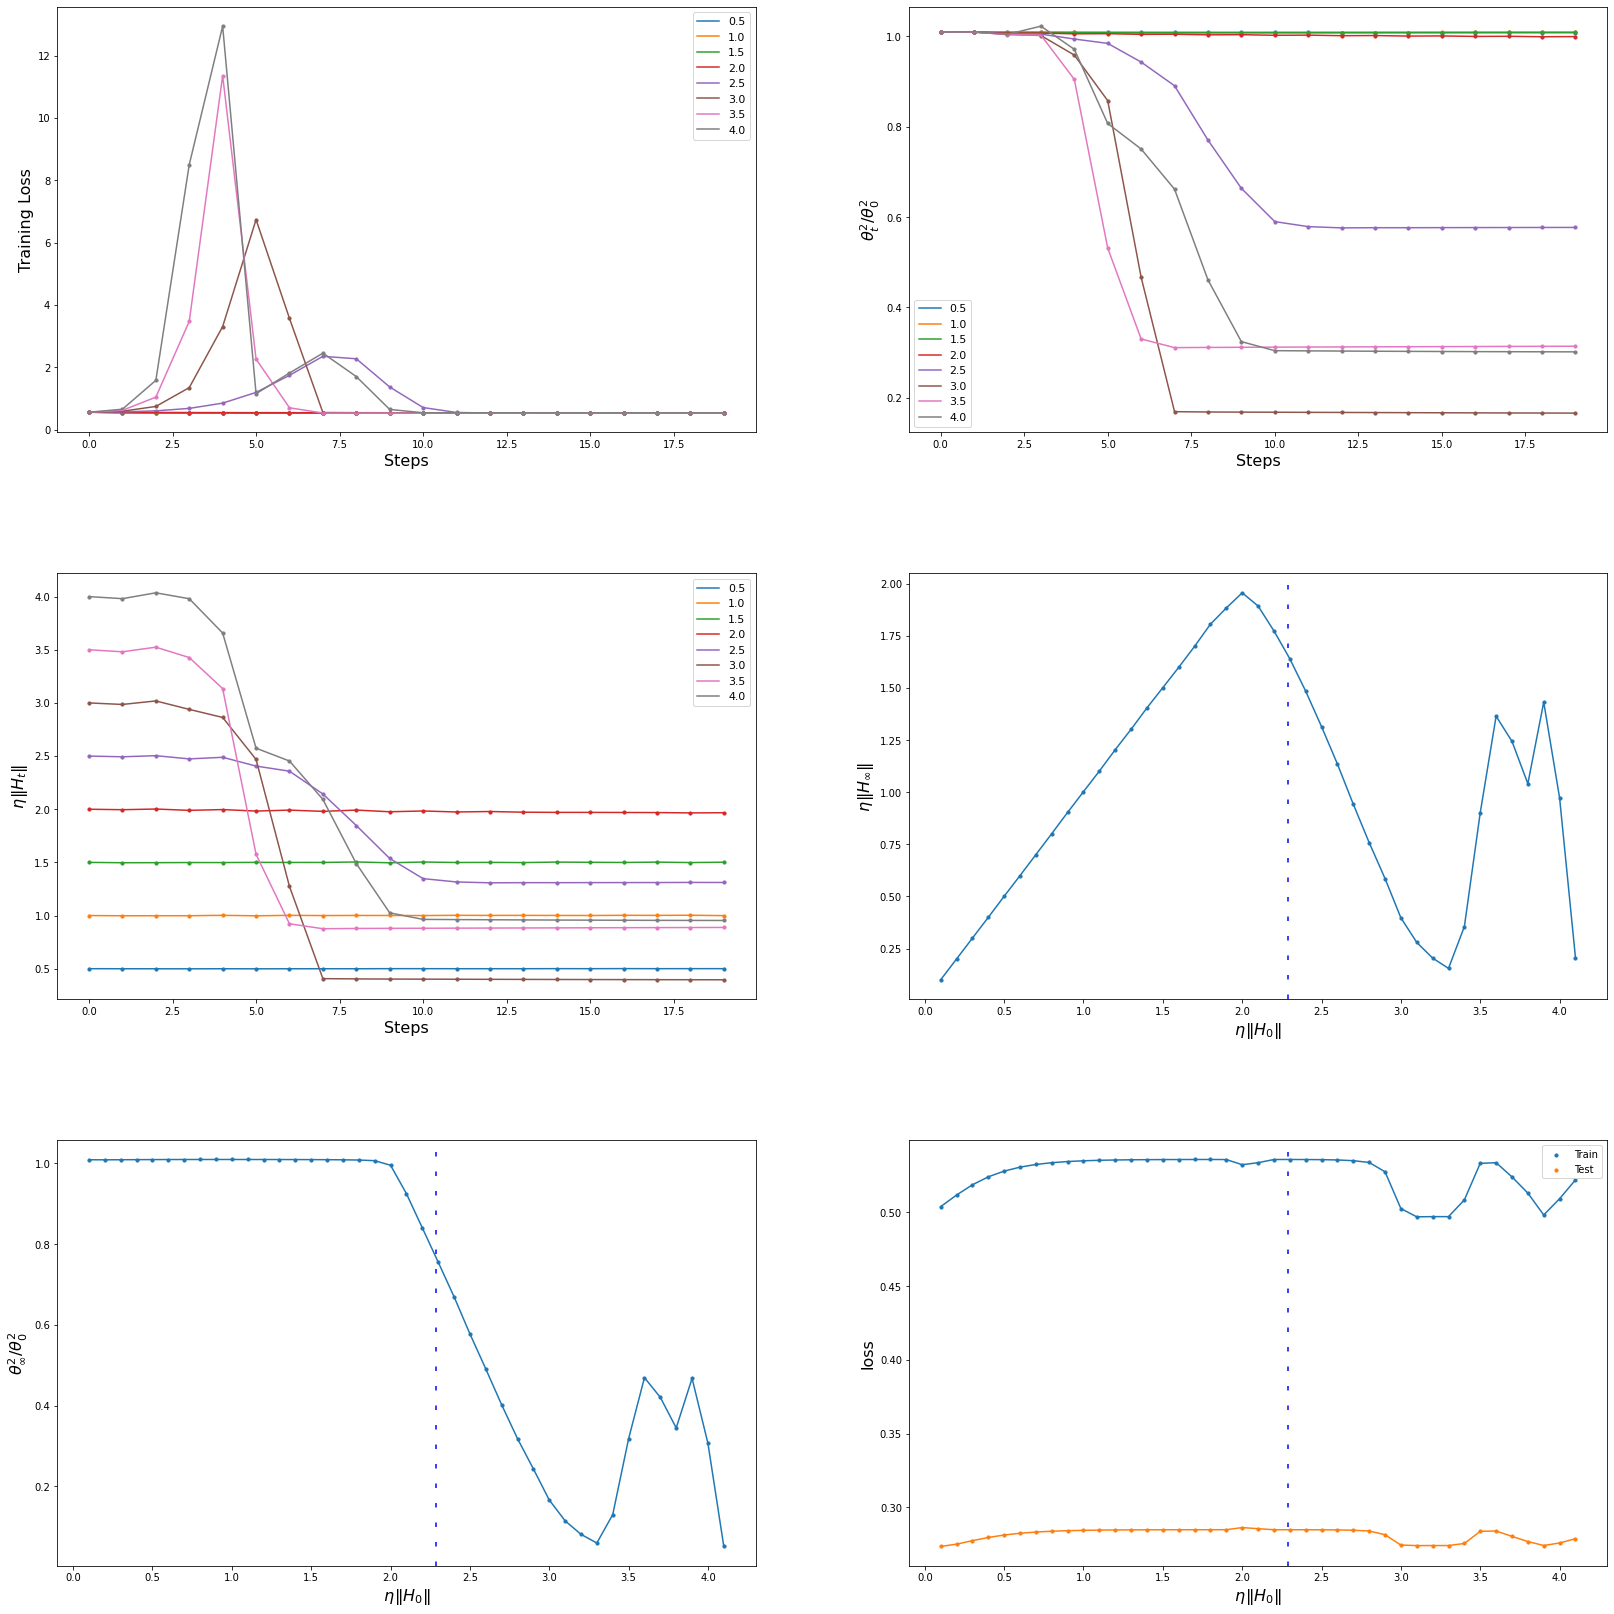

In [ ]:
arch=MLPGeneral

model_dict={}
model_dict['input_size']=1
model_dict['width']=1024
model_dict['activation']='leaky_relu'
model_dict['num_hidden_layers']=1
model_dict['bias_value']=False
num_train_samps=32
num_test_samps=50
train_batch_size=num_train_samps

seed=120

lr_ratios=list(map(lambda x: np.round(x,2),list(np.arange(0.1,6+.1,.1))))

X_train=(torch.rand((num_train_samps,model_dict['input_size']))-1/2)
y_train=torch.randn((num_train_samps,1))

X_test=(torch.rand((num_test_samps,model_dict['input_size']))-1/2)
y_test=torch.randn((num_test_samps,1))

dataset={}
dataset['name']='random'
dataset['train']=CustomDataset(list(zip(X_train,y_train)))
dataset['test']=CustomDataset(list(zip(X_test,y_test)))

max_epochs=50
stop_criterion=0

model_dict['slope']=.5
slope=np.round(.5,3)

result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None,
                    device=device,
                    seed=seed,
                    printevery=250,
                    verbose=True,
                    write_file=save_files,
                    overwrite=False,
                    data_eigen=True)

produce_plots(result,
              xmin=0,
              xmax=20,
              include_predictions=True,
              mult_data=False,
              s=10,
              size=(25,25),
              offset=4,
              skip=5)

## Figure 10: ReLU, Two-Layer, Simple dataset

computing averaged top eigenvalues and eigenvectors
eigenvalues already computed

Training at lr_ratio: 0.1
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1

Training at lr_ratio: 0.2
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1

Training at lr_ratio: 0.3
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1

Training at lr_ratio: 0.4
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1

Training at lr_ratio: 0.5
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1

Training at lr_ratio: 0.6
training already done
Computing final values of train and

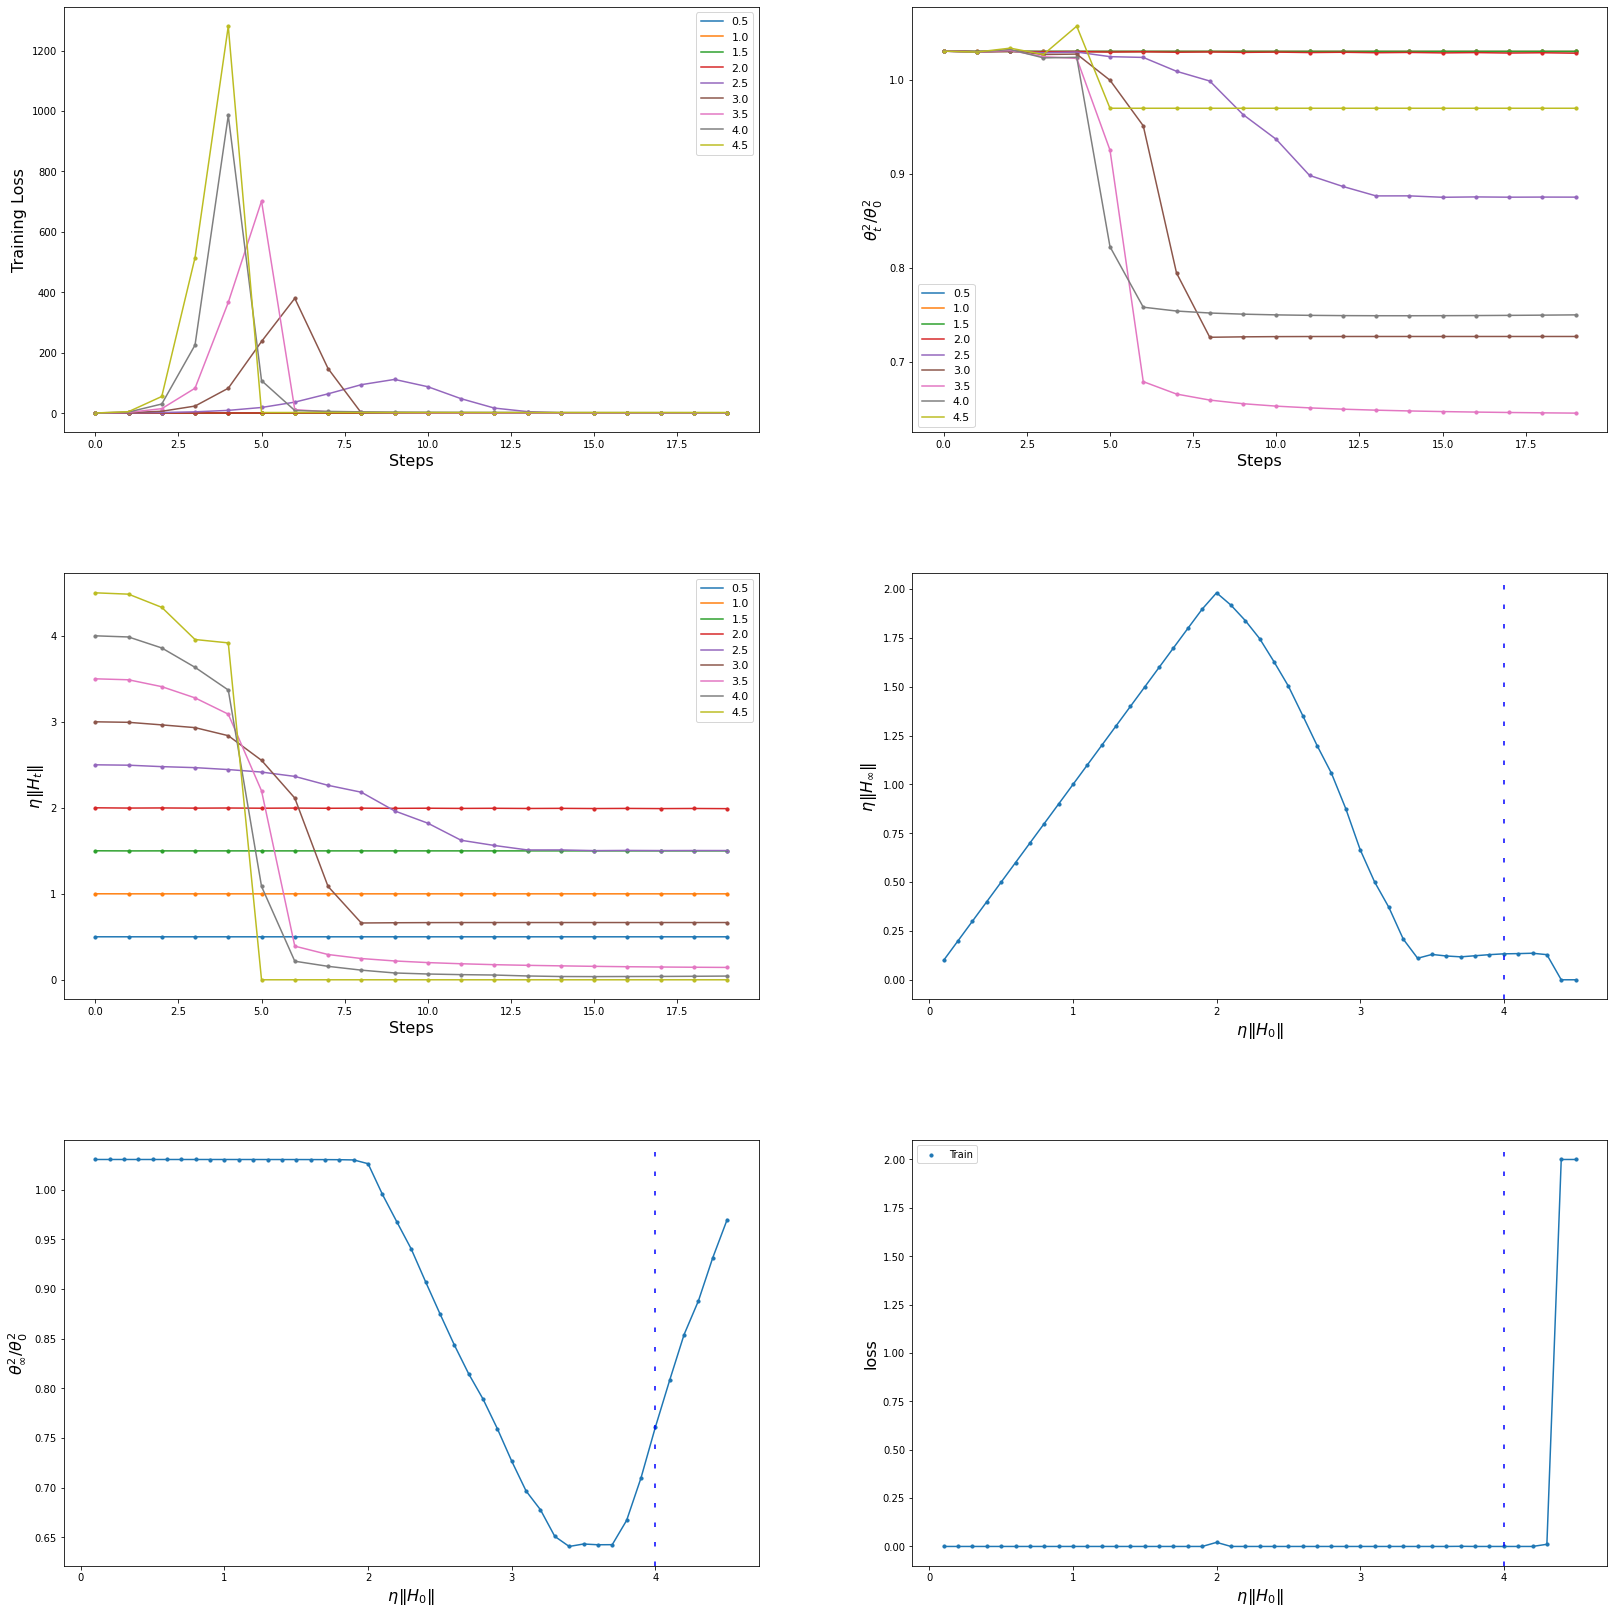

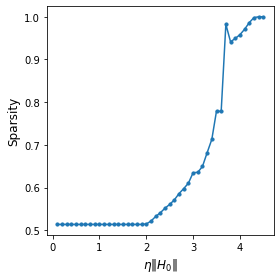

In [ ]:
arch=MLPGeneral

model_dict={}
model_dict['input_size']=1
model_dict['width']=1024
model_dict['activation']='leaky_relu'
model_dict['num_hidden_layers']=1
model_dict['bias_value']=False
num_train_samps=1
train_batch_size=num_train_samps

seed=123

lr_ratios=list(map(lambda x: np.round(x,2),list(np.arange(0.1,6+.1,.1))))

X_train=torch.tensor([[4.]])
y_train=torch.tensor([[2.]])

dataset={}
dataset['name']='simple'
dataset['train']=CustomDataset(list(zip(X_train,y_train)))


lr_ratios=list(map(lambda x: round(x,3),np.arange(0.1,4.5+.1,.1)))
#lr_ratios=[1]
max_epochs=100
stop_criterion=0

model_dict['slope']=0


result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None,
                    device=device,
                    seed=seed,
                    printevery=250,
                    verbose=True,
                    write_file=save_files,
                    overwrite=False,
                    data_eigen=True)

produce_plots(result,
              xmin=0,
              xmax=20,
              include_predictions=True,
              mult_data=False,
              s=10,
              size=(25,25),
              offset=4,
              skip=5)

## Figure 11: ReLU, Two-Layers, Two-Class MNIST, zoomed in

computing averaged top eigenvalues and eigenvectors
eigenvalues already computed

Training at lr_ratio: 0.5
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/17

Training at lr_ratio: 1.0
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/17

Training at lr_ratio: 1.5
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/17

Training at lr_ratio: 2.0
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/17

Training at lr_ratio: 2.5
training already done
Computing final values of train and/or test loss.
Computing final valu

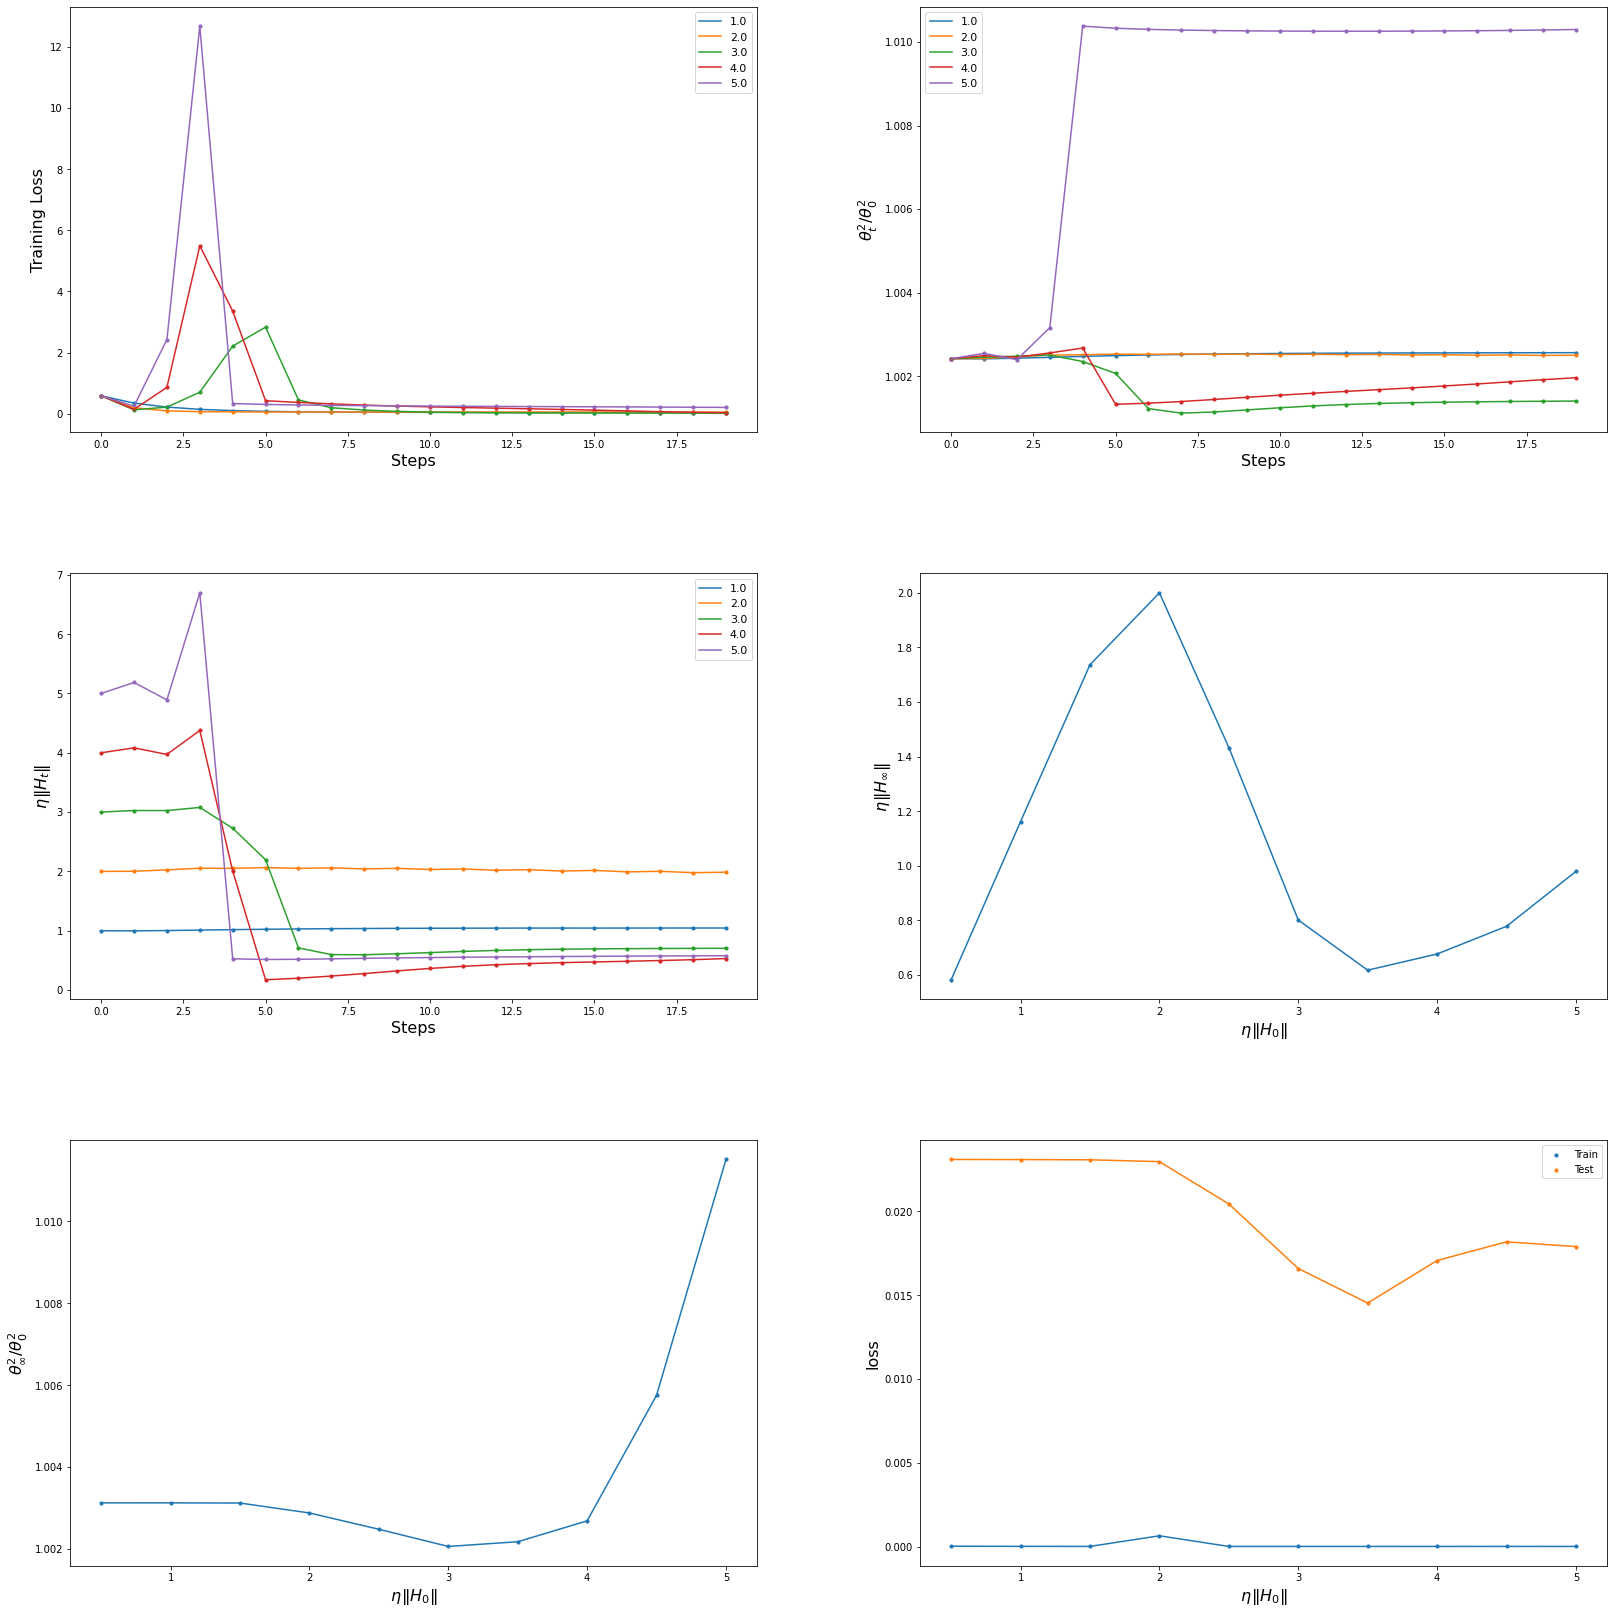

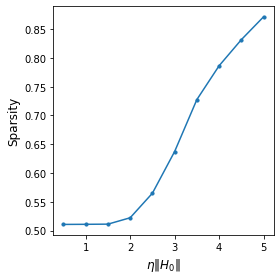

In [ ]:
arch=MLPGeneral

model_dict={}
model_dict['input_size']=28**2
model_dict['width']=1024
model_dict['activation']='relu'
model_dict['num_hidden_layers']=1
model_dict['bias_value']=False

dataset={}
dataset['name']='MNIST01_small_zoom'
dataset['train']=data['MNIST01_small','train']
dataset['test']=data['MNIST01_small','test']
train_batch_size=len(dataset['train'])

lr_ratios=np.arange(0.5,5+.5,.5)
max_epochs=100000
stop_criterion=10**-8

seed=123

result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None,
                    device=device,
                    seed=seed,
                    printevery=1000,
                    verbose=True,
                    write_file=save_files,
                    overwrite=False,
                    data_eigen=False)

produce_plots(result,
              xmin=0,
              xmax=20,
              include_predictions=False,
              mult_data=False,
              s=10,
              size=(25,25),
              offset=1,
              skip=2)

## Figure 12: ReLU, Two-Layers, Two-Class FMNIST.

computing averaged top eigenvalues and eigenvectors
eigenvalues already computed

Training at lr_ratio: 0.5
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/79

Training at lr_ratio: 1.0
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/79

Training at lr_ratio: 1.5
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/79

Training at lr_ratio: 2.0
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/79

Training at lr_ratio: 2.5
training already done
Computing final values of train and/or test loss.
Computing final valu

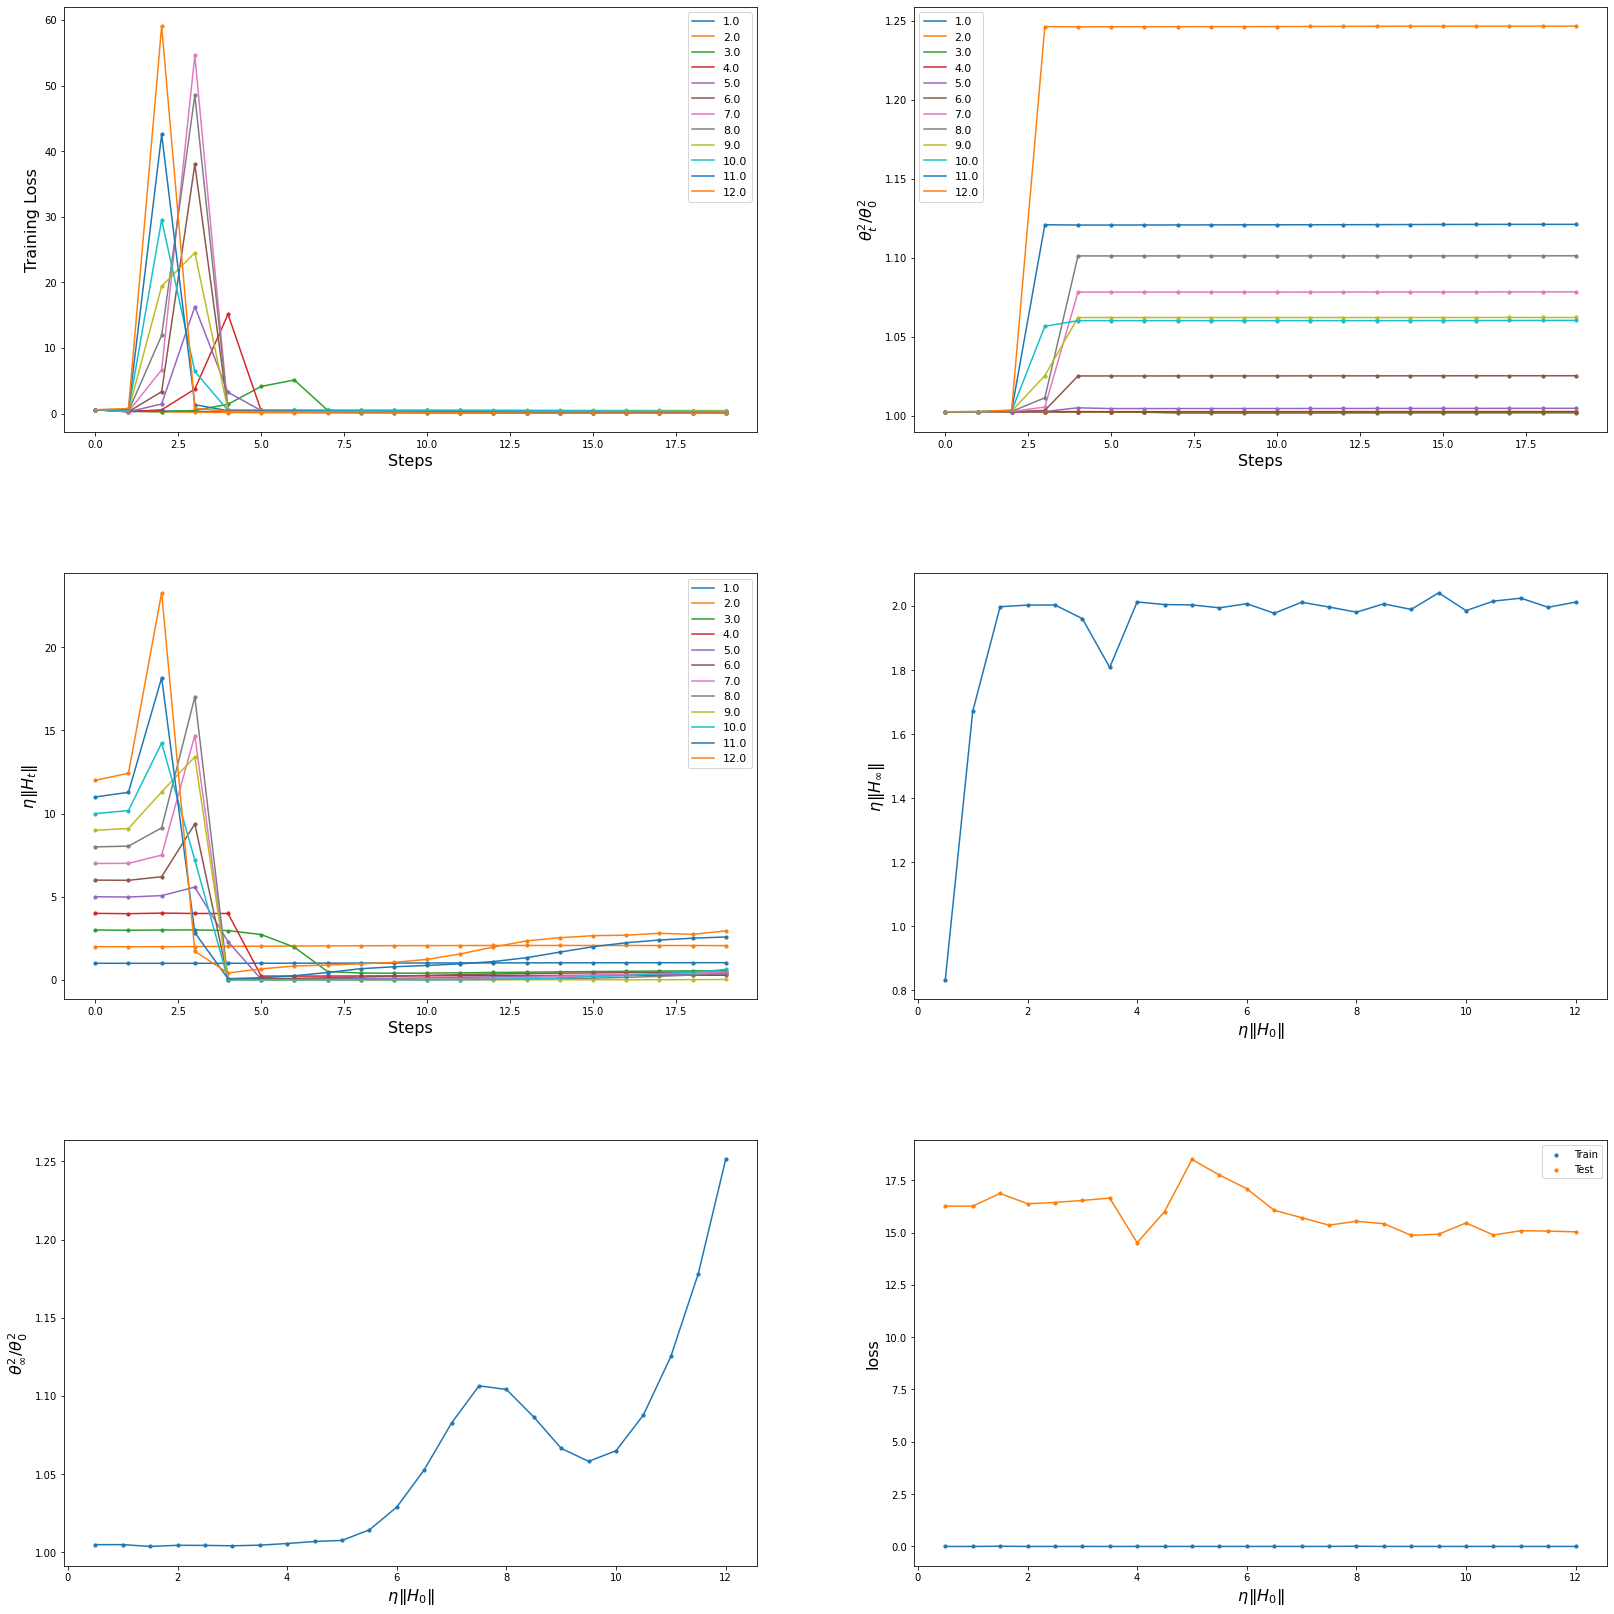

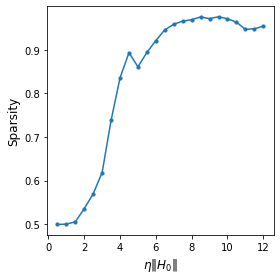

In [ ]:
arch=MLPGeneral

model_dict={}
model_dict['input_size']=28**2
model_dict['width']=1024
model_dict['activation']='relu'
model_dict['num_hidden_layers']=1
model_dict['bias_value']=False

dataset={}
dataset['name']='FMNIST01_small'
dataset['train']=data['FMNIST01_small','train']
dataset['test']=data['FMNIST01_small','test']
train_batch_size=len(dataset['train'])

lr_ratios=np.arange(0.5,12+.5,.5)
max_epochs=100000
stop_criterion=10**-8

seed=123

result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None,
                    device=device,
                    seed=seed,
                    printevery=1000,
                    verbose=True,
                    write_file=save_files,
                    overwrite=False,
                    data_eigen=False)

produce_plots(result,
              xmin=0,
              xmax=20,
              include_predictions=False,
              mult_data=False,
              s=10,
              size=(25,25),
              offset=1,
              skip=2)

## Figure 13: ReLU, Two-Layers, Two-Class CIFAR-10.

computing averaged top eigenvalues and eigenvectors
eigenvalues already computed

Training at lr_ratio: 0.5
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/16

Training at lr_ratio: 1.0
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/16

Training at lr_ratio: 1.5
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/16

Training at lr_ratio: 2.0
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/16

Training at lr_ratio: 2.5
training already done
Computing final values of train and/or test loss.
Computing final valu

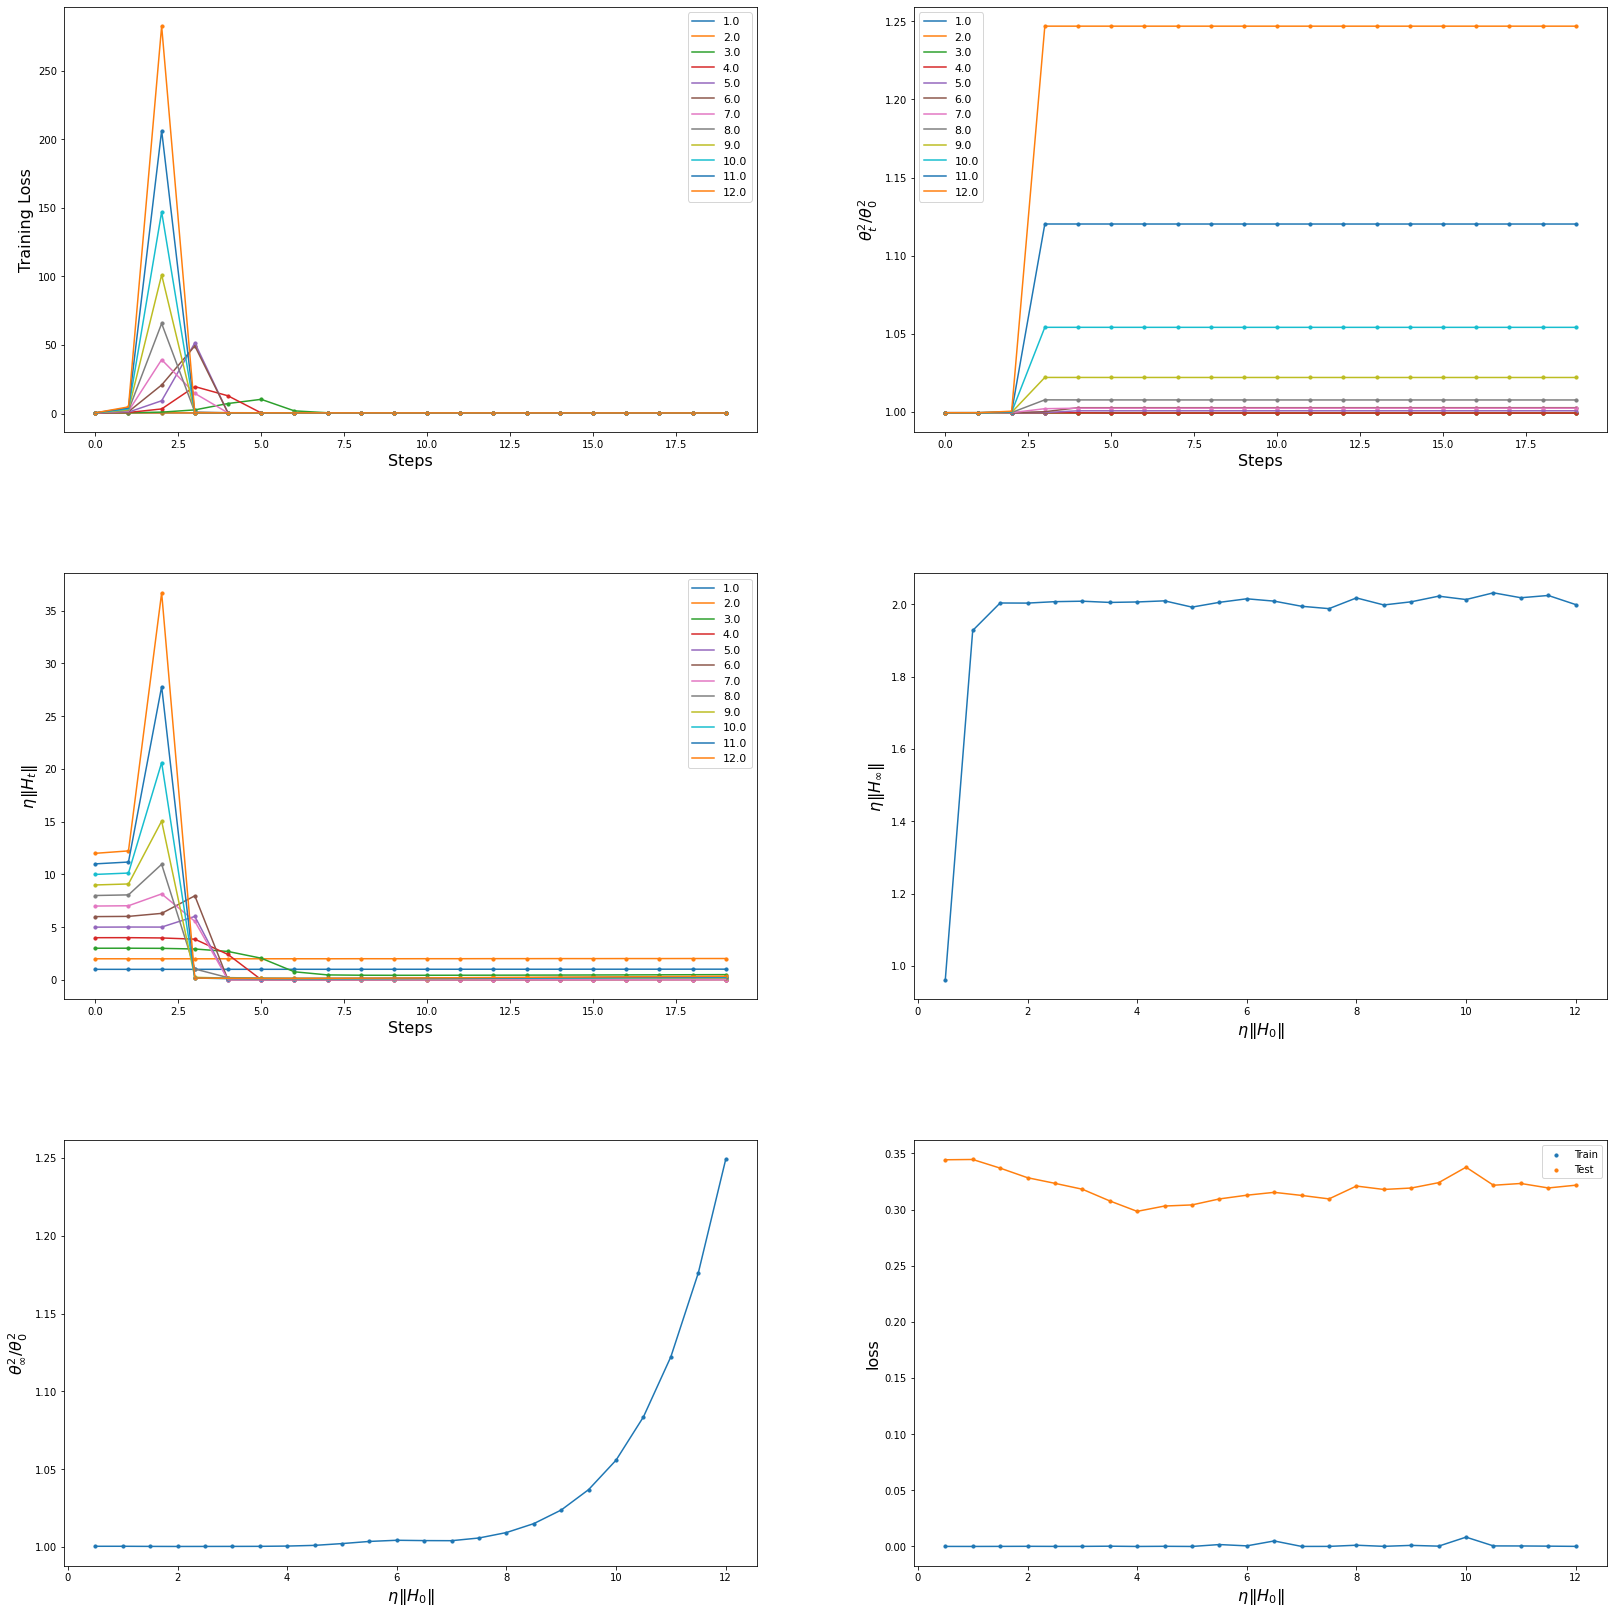

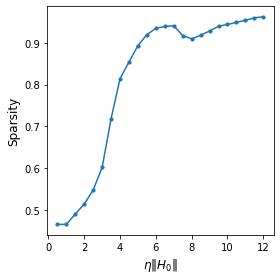

In [ ]:
arch=MLPGeneral

model_dict={}
model_dict['input_size']=3*32**2
model_dict['width']=1024
model_dict['activation']='relu'
model_dict['num_hidden_layers']=1
model_dict['bias_value']=False

dataset={}
dataset['name']='CIFAR10_01_small'
dataset['train']=data['CIFAR10_01_small','train']
dataset['test']=data['CIFAR10_01_small','test']
train_batch_size=len(dataset['train'])

lr_ratios=np.arange(0.5,12+.5,.5)
max_epochs=100000
stop_criterion=10**-8

seed=123

result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None,
                    device=device,
                    seed=seed,
                    printevery=1000,
                    verbose=True,
                    write_file=save_files,
                    overwrite=False,
                    data_eigen=False)

produce_plots(result,
              xmin=0,
              xmax=20,
              include_predictions=False,
              mult_data=False,
              s=10,
              size=(25,25),
              offset=1,
              skip=2)

## Figure 14: ReLU, Three-Layers, Two-Class MNIST.

In [ ]:
arch=MLPGeneral

model_dict={}
model_dict['input_size']=28**2
model_dict['width']=1024
model_dict['activation']='relu'
model_dict['num_hidden_layers']=2
model_dict['bias_value']=False

dataset={}
dataset['name']='MNIST01_small'
dataset['train']=data['MNIST01_small','train']
dataset['test']=data['MNIST01_small','test']
train_batch_size=len(dataset['train'])

lr_ratios=np.arange(0.5,12+.5,.5)
max_epochs=100000
stop_criterion=10**-8

seed=123

result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None,
                    device=device,
                    seed=seed,
                    printevery=1000,
                    verbose=True,
                    write_file=save_files,
                    overwrite=False,
                    data_eigen=False)

produce_plots(result,
              xmin=0,
              xmax=20,
              include_predictions=False,
              mult_data=False,
              s=10,
              size=(25,25),
              offset=1,
              skip=4)

## Figure 15: ReLU, Three-Layers, Two-Class FMNIST.

computing averaged top eigenvalues and eigenvectors
eigenvalues already computed

Training at lr_ratio: 0.5
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/79

Training at lr_ratio: 1.0
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/79

Training at lr_ratio: 1.5
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/79

Training at lr_ratio: 2.0
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/79

Training at lr_ratio: 2.5
training already done
Computing final values of train and/or test loss.
Computing final valu

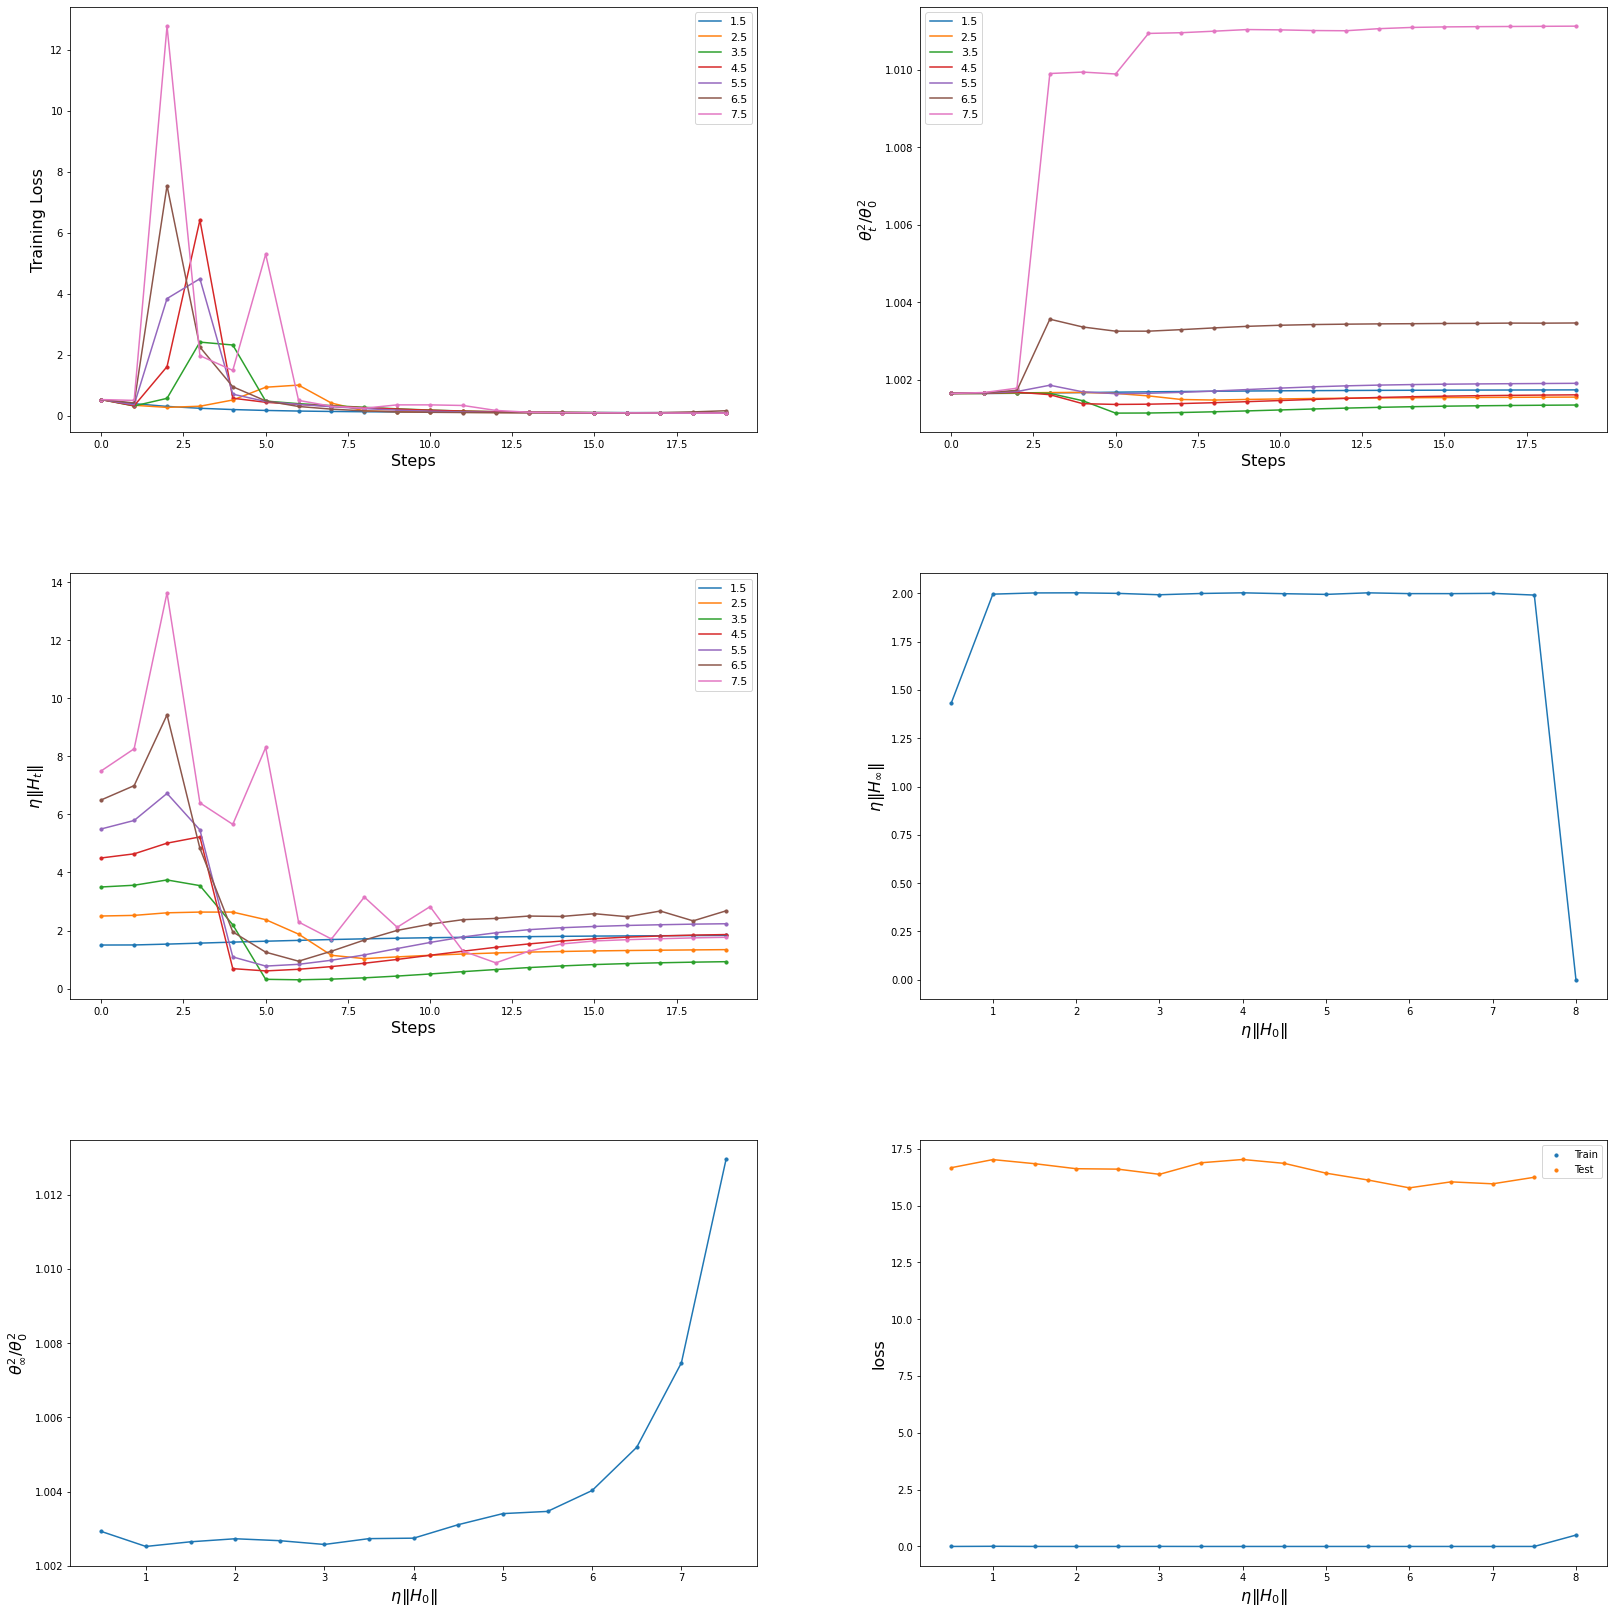

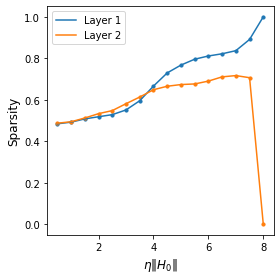

In [ ]:
arch=MLPGeneral

model_dict={}
model_dict['input_size']=28**2
model_dict['width']=1024
model_dict['activation']='relu'
model_dict['num_hidden_layers']=2
model_dict['bias_value']=False

dataset={}
dataset['name']='FMNIST01_small'
dataset['train']=data['FMNIST01_small','train']
dataset['test']=data['FMNIST01_small','test']
train_batch_size=len(dataset['train'])

lr_ratios=np.arange(0.5,8+.5,.5)
max_epochs=100000
stop_criterion=10**-8

seed=123

result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None,
                    device=device,
                    seed=seed,
                    printevery=1000,
                    verbose=True,
                    write_file=save_files,
                    overwrite=False,
                    data_eigen=False)

produce_plots(result,
              xmin=0,
              xmax=20,
              include_predictions=False,
              mult_data=False,
              s=10,
              size=(25,25),
              offset=2,
              skip=2)

## Figure 16: ReLU, Three-Layers, Two-Class CIFAR-10.

computing averaged top eigenvalues and eigenvectors
eigenvalues already computed

Training at lr_ratio: 0.5
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/16

Training at lr_ratio: 1.0
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/16

Training at lr_ratio: 1.5
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/16

Training at lr_ratio: 2.0
training already done
Computing final values of train and/or test loss.
Computing final value of sparsity.
Partition train, batch/total 0/1
Partition test, batch/total 0/16

Training at lr_ratio: 2.5
training already done
Computing final values of train and/or test loss.
Computing final valu

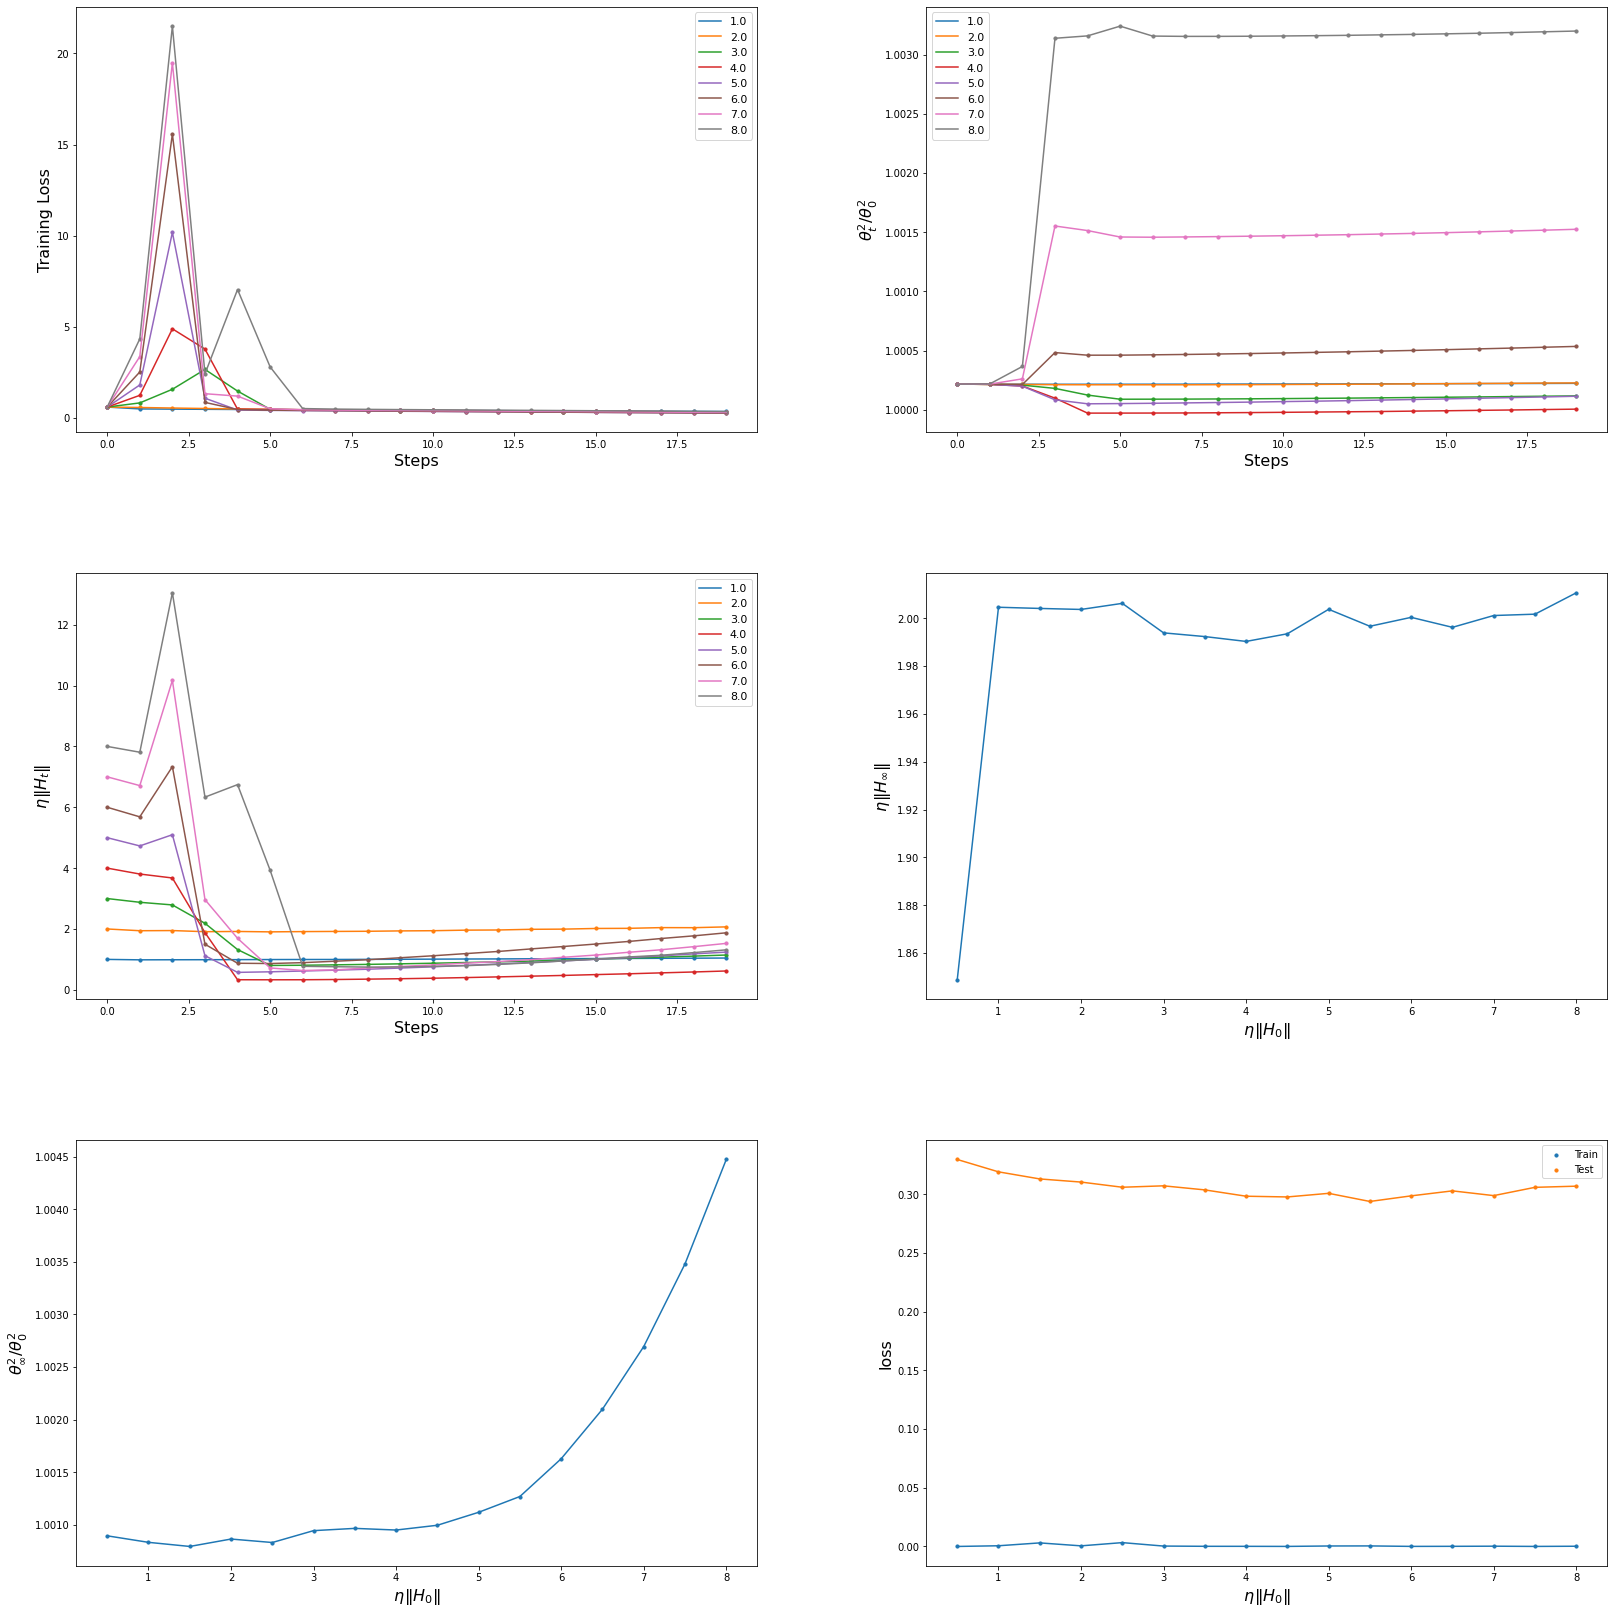

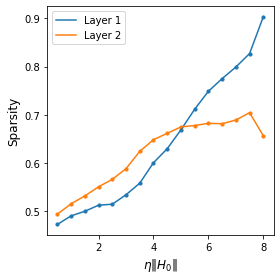

In [ ]:
arch=MLPGeneral

model_dict={}
model_dict['input_size']=3*32**2
model_dict['width']=1024
model_dict['activation']='relu'
model_dict['num_hidden_layers']=2
model_dict['bias_value']=False

dataset={}
dataset['name']='CIFAR10_01_small'
dataset['train']=data['CIFAR10_01_small','train']
dataset['test']=data['CIFAR10_01_small','test']
train_batch_size=len(dataset['train'])

lr_ratios=np.arange(0.5,8+.5,.5)
max_epochs=100000
stop_criterion=10**-8

seed=123

result=full_training_loop(arch,
                    model_dict,
                    lr_ratios,
                    dataset,
                    train_batch_size,
                    max_epochs=max_epochs,
                    stop_criterion=stop_criterion,
                    reading_path=None,
                    device=device,
                    seed=seed,
                    printevery=1000,
                    verbose=True,
                    write_file=save_files,
                    overwrite=False,
                    data_eigen=False)

produce_plots(result,
              xmin=0,
              xmax=20,
              include_predictions=False,
              mult_data=False,
              s=10,
              size=(25,25),
              offset=1,
              skip=2)